# **Imports and Set-up**

In [5]:
import pandas as pd
import json
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import spacy
import transformers
import torch
import networkx as nx
import collections
import pmdarima as pm
import community as community_louvain

from collections import Counter
from statsforecast import StatsForecast
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsforecast.models import AutoARIMA
from pmdarima import auto_arima
from collections import deque
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.nn.functional import softmax
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, KNNBasic
from collections import defaultdict
from geopy.distance import geodesic
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from surprise.accuracy import rmse
from sklearn.metrics import mean_squared_error, precision_score, recall_score, mean_absolute_error, make_scorer
from sklearn.metrics.pairwise import cosine_similarity
from math import sqrt
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from tqdm import tqdm

### Load preprocessed datasets

In [2]:
df_review = pd.read_csv("data/processed_reviews_sentiment.csv")
df_business = pd.read_csv("data/processed_business.csv")
df_user = pd.read_csv("data/processed_users.csv")
print("\n Data loaded!\n")



 Data loaded!



### Load unpreprocessed datasets

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
def load_yelp_data(file_path, nrows=None):
    data = []
    print(f" Loading: {file_path}...")  

    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if nrows and i >= nrows:
                break
            data.append(json.loads(line))
            
            if (i + 1) % 100000 == 0:
                print(f"   {i + 1} loaded lines...")

    print(f" {file_path} loaded with {len(data)} lines!\n")  
    return pd.DataFrame(data)

print("\n Starting to load datasets...\n")




 Starting to load datasets...



In [ ]:

df_business = load_yelp_data("data/yelp_academic_dataset_business.json")
df_review = load_yelp_data("data/sparks_reviews.json")
df_user = load_yelp_data("data/yelp_academic_dataset_user.json") 

 Loading: data/yelp_academic_dataset_business.json...
  🔄 100000 loaded lines...
 data/yelp_academic_dataset_business.json loaded with 150346 lines!

 Loading: data/yelp_academic_dataset_user.json...
  🔄 100000 loaded lines...
  🔄 200000 loaded lines...
  🔄 300000 loaded lines...
  🔄 400000 loaded lines...
  🔄 500000 loaded lines...
  🔄 600000 loaded lines...
  🔄 700000 loaded lines...
  🔄 800000 loaded lines...
  🔄 900000 loaded lines...
  🔄 1000000 loaded lines...
  🔄 1100000 loaded lines...
  🔄 1200000 loaded lines...
  🔄 1300000 loaded lines...
  🔄 1400000 loaded lines...
  🔄 1500000 loaded lines...
  🔄 1600000 loaded lines...
  🔄 1700000 loaded lines...
  🔄 1800000 loaded lines...
  🔄 1900000 loaded lines...
 data/yelp_academic_dataset_user.json loaded with 1987897 lines!




## Restaurants in Spark city

In [67]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25


In [ ]:
df_business = df_business[df_business['categories'].str.contains('Restaurants', na=False)]
df_business = df_business.reset_index(drop=True)
df_business = df_business[df_business['business_id'].isin(df_review['business_id'])]
df_business = df_business.reset_index(drop=True)
df_business.shape


(334, 14)

In [69]:
df_user = df_user[df_user['user_id'].isin(df_review['user_id'])]


## EDA


In [4]:
missing_values = df_review.isnull().sum()
print("Missing values per column:\n", missing_values)



Missing values per column:
 review_id          0
user_id            0
business_id        0
stars              0
useful             0
funny              0
cool               0
text               0
date               0
review_length      0
sentiment          0
year               0
clean_text         0
sentiment_score    0
dtype: int64


In [5]:
print(f"Total size of df: {len(df_review)}")
print(f"Number of unique entries in 'narrative': {len(df_review['text'].unique())}")

Total size of df: 40186
Number of unique entries in 'narrative': 40094


In [6]:
df_review = df_review.drop_duplicates(subset=["text","stars"], keep="first").reset_index(drop=True)

In [7]:
print(f"Total size of df: {len(df_review)}")


Total size of df: 40101


* Different Type of Restaurants and their Count

<Axes: >

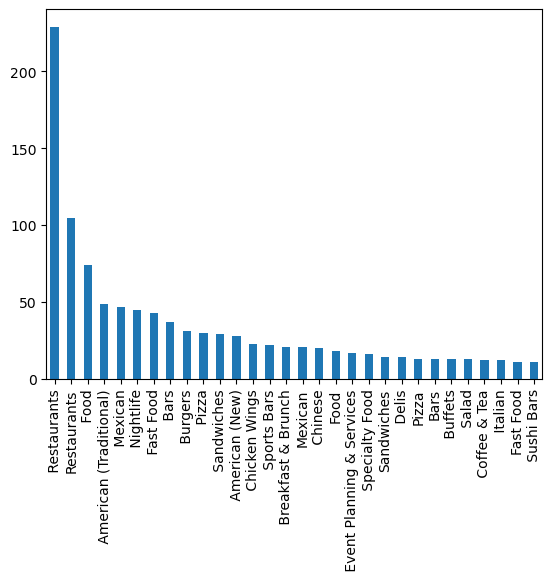

In [8]:
uniq_cat_dict = {}
for i in df_business['categories']:
    cat = str(i).split(',')
    for j in cat:
        if j not in uniq_cat_dict.keys():
            uniq_cat_dict[j] = 1
        else:
            uniq_cat_dict[j] += 1
uniq_cat_series = pd.Series(uniq_cat_dict)
uniq_cat_series.sort_values(ascending = False, inplace = True)
uniq_cat_series[:30].plot(kind = 'bar')

In [9]:
df_business.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Lx8ZYUJ_-3Aa8N821mN1WQ,ALM Kainan,"390 N McCarran Blvd, Ste B",Sparks,NV,89434,39.537179,-119.735532,4.0,13,0,"{'RestaurantsAttire': ""u'casual'"", 'HasTV': 'F...","Restaurants, Filipino","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'..."
1,UX3eq0WsVva-cqlVrzyzFg,Cantina Los Tres Hombres,926 Victorian Ave,Sparks,NV,89431,39.535111,-119.754857,3.0,284,1,"{'HasTV': 'True', 'RestaurantsPriceRange2': '2...","Bars, Nightlife, Mexican, Restaurants, Seafood","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
2,YhQAQhG1IkXJH7oLZMbM9w,Del Taco,252 Los Altos Pkwy,Sparks,NV,89431,39.583653,-119.740935,1.5,60,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Restaurants, Fast Food, Mexican","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ..."
3,qbPsfIKJZQAlrPaYmSyZuQ,All Wrapped Up,NaN,Sparks,NV,89431,39.540154,-119.748395,4.0,7,1,"{'RestaurantsDelivery': 'False', 'GoodForMeal'...","Food Trucks, Food, Salad, Sandwiches, Caterers...",NaN
4,V4THIJk9uhoxL7f06fK5VA,Roundabout Catering,631 Dunn Cir,Sparks,NV,89431,39.528286,-119.734864,5.0,38,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Caterers, Party Equipment Rentals, Food, Venue...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."


In [ ]:
df_business.shape

(334, 14)

In [ ]:
df_business.describe()

,latitude,longitude,stars,review_count,is_open
count,334.000000,334.000000,334.000000,334.000000,334.000000
mean,39.550736,-119.736836,3.407186,114.386228,0.718563
std,0.025439,0.025591,0.821306,156.482786,0.450375
min,39.520643,-119.813527,1.500000,5.000000,0.000000
25%,39.534481,-119.753786,3.000000,25.250000,0.000000
50%,39.541638,-119.738714,3.500000,60.000000,1.000000
75%,39.556945,-119.719900,4.000000,133.750000,1.000000
max,39.640527,-119.556307,5.000000,1576.000000,1.000000


In [ ]:
df_user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
39,AkBtT43dYcttxQ3qOzPBAg,Sherri,1034,2007-02-20 18:21:07,3066,1485,2235,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2016","Hg1EF9PjGfcKBSNMjvWBeQ, PcPminF0bIUsKjUh9e4DMQ...",114,...,26,24,83,23,229,570,528,528,118,50
55,2l0O1EI1m0yWjFo2zSt71w,Shiho,2837,2005-07-02 01:59:55,19237,9542,15235,"2006,2007,2008,2009,2010,2011","ZxigNlfaGmqtC1CROVu9Dg, XKAFikZAfddYv0Vg1PUkwA...",492,...,108,85,79,40,350,742,1070,1070,403,258
65,YuRfPsIME6v5qYr3GfFzrg,Eric,57,2011-03-18 22:52:43,22,3,3,,"sp4yvAwatFx7gnlqtqNs9Q, lvI1TNSbnw8oAFy6JVswGg...",2,...,0,0,0,0,2,0,0,0,0,0


In [ ]:
df_review.head()
df_review.shape


(40186, 9)

In [ ]:
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Lx8ZYUJ_-3Aa8N821mN1WQ,ALM Kainan,"390 N McCarran Blvd, Ste B",Sparks,NV,89434,39.537179,-119.735532,4.0,13,0,"{'RestaurantsAttire': 'u'casual'', 'HasTV': 'F...","Restaurants, Filipino","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'..."
1,UX3eq0WsVva-cqlVrzyzFg,Cantina Los Tres Hombres,926 Victorian Ave,Sparks,NV,89431,39.535111,-119.754857,3.0,284,1,"{'HasTV': 'True', 'RestaurantsPriceRange2': '2...","Bars, Nightlife, Mexican, Restaurants, Seafood","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
2,YhQAQhG1IkXJH7oLZMbM9w,Del Taco,252 Los Altos Pkwy,Sparks,NV,89431,39.583653,-119.740935,1.5,60,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Restaurants, Fast Food, Mexican","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ..."
3,qbPsfIKJZQAlrPaYmSyZuQ,All Wrapped Up,,Sparks,NV,89431,39.540154,-119.748395,4.0,7,1,"{'RestaurantsDelivery': 'False', 'GoodForMeal'...","Food Trucks, Food, Salad, Sandwiches, Caterers...",None
4,V4THIJk9uhoxL7f06fK5VA,Roundabout Catering,631 Dunn Cir,Sparks,NV,89431,39.528286,-119.734864,5.0,38,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Caterers, Party Equipment Rentals, Food, Venue...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."


In [ ]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25


In [ ]:
df_review.shape

(40186, 9)

In [ ]:
df_review.describe()

,stars,useful,funny,cool
count,40186.000000,40186.000000,40186.000000,40186.000000
mean,3.594038,1.277709,0.306574,0.691086
std,1.542312,2.868504,1.315701,2.242514
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000,1.000000
max,5.000000,217.000000,103.000000,201.000000


In [ ]:
df_user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
39,AkBtT43dYcttxQ3qOzPBAg,Sherri,1034,2007-02-20 18:21:07,3066,1485,2235,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2016","Hg1EF9PjGfcKBSNMjvWBeQ, PcPminF0bIUsKjUh9e4DMQ...",114,...,26,24,83,23,229,570,528,528,118,50
55,2l0O1EI1m0yWjFo2zSt71w,Shiho,2837,2005-07-02 01:59:55,19237,9542,15235,"2006,2007,2008,2009,2010,2011","ZxigNlfaGmqtC1CROVu9Dg, XKAFikZAfddYv0Vg1PUkwA...",492,...,108,85,79,40,350,742,1070,1070,403,258
65,YuRfPsIME6v5qYr3GfFzrg,Eric,57,2011-03-18 22:52:43,22,3,3,,"sp4yvAwatFx7gnlqtqNs9Q, lvI1TNSbnw8oAFy6JVswGg...",2,...,0,0,0,0,2,0,0,0,0,0


In [ ]:
df_user.shape

(20175, 22)

In [ ]:
df_user.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000
mean,48.888625,142.260173,60.979827,98.878017,3.622602,3.611492,6.593507,0.783742,0.564164,0.337447,0.159009,4.442032,12.485056,10.933036,10.933036,3.574275,4.683916
std,222.204144,1775.292759,961.849500,1533.973447,37.408737,1.020159,118.188936,11.053856,14.508433,6.942779,4.124523,62.292047,306.445150,194.252467,194.252467,47.518972,115.609751
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.000000,8.000000,1.000000,2.000000,0.000000,3.790000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.000000,32.000000,6.000000,10.000000,1.000000,4.330000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,16978.000000,152979.000000,84992.000000,125516.000000,3642.000000,5.000000,6615.000000,735.000000,1435.000000,464.000000,278.000000,3325.000000,28974.000000,11595.000000,11595.000000,2731.000000,9780.000000


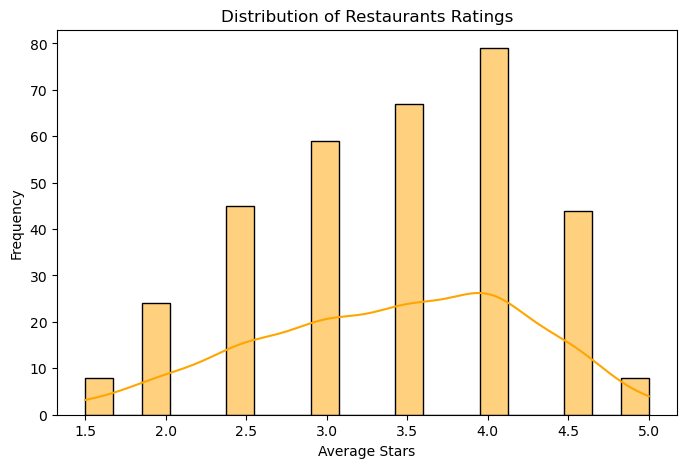

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(df_business['stars'], bins=20, kde=True, color="orange")
plt.title("Distribution of Restaurants Ratings")
plt.xlabel("Average Stars")
plt.ylabel("Frequency")
plt.show()


/tmp/ipykernel_6341/3493975731.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_business, x="name", y="review_count", palette="Blues_d")


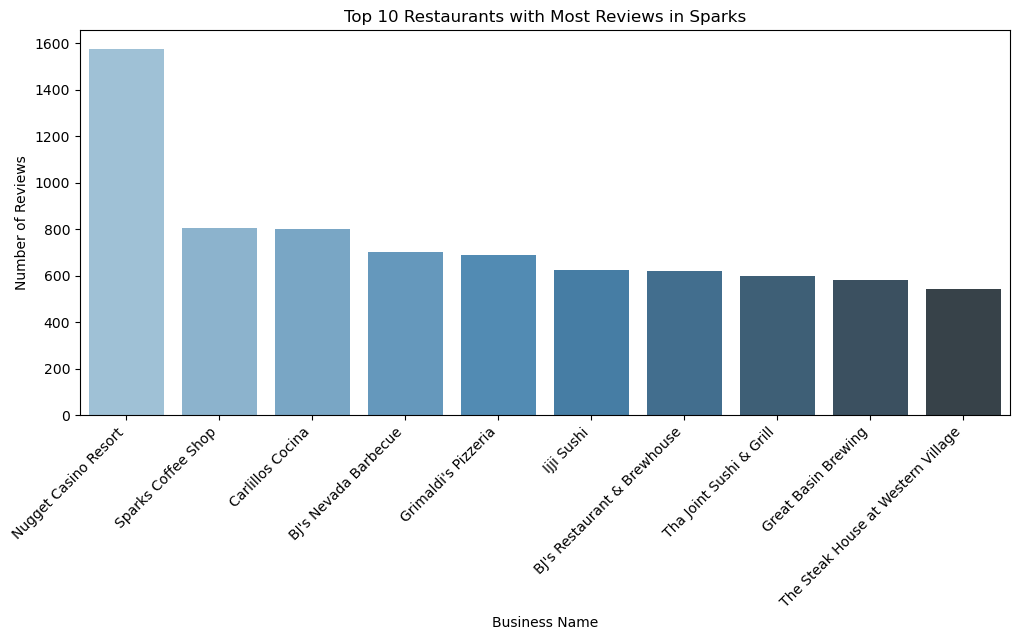

In [11]:
top_business = df_business.nlargest(10, 'review_count')

plt.figure(figsize=(12, 5))
sns.barplot(data=top_business, x="name", y="review_count", palette="Blues_d")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Restaurants with Most Reviews in Sparks")
plt.xlabel("Business Name")
plt.ylabel("Number of Reviews")
plt.show()


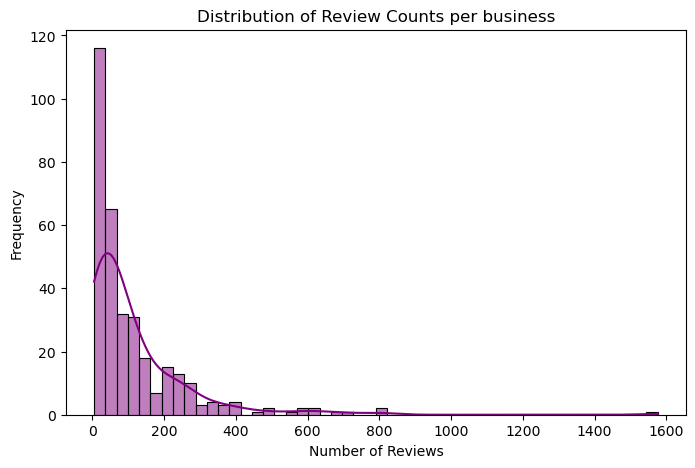

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_business['review_count'], bins=50, kde=True, color="purple")
plt.title("Distribution of Review Counts per business")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
plt.show()


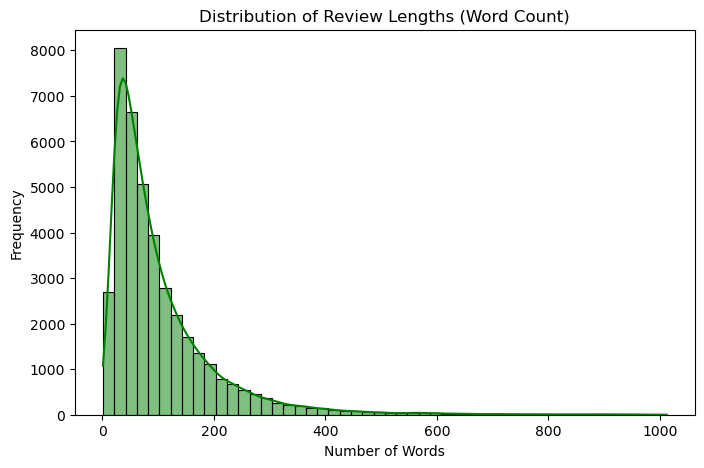

In [13]:
df_review["review_length"] = df_review["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df_review["review_length"], bins=50, kde=True, color="green")
plt.title("Distribution of Review Lengths (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


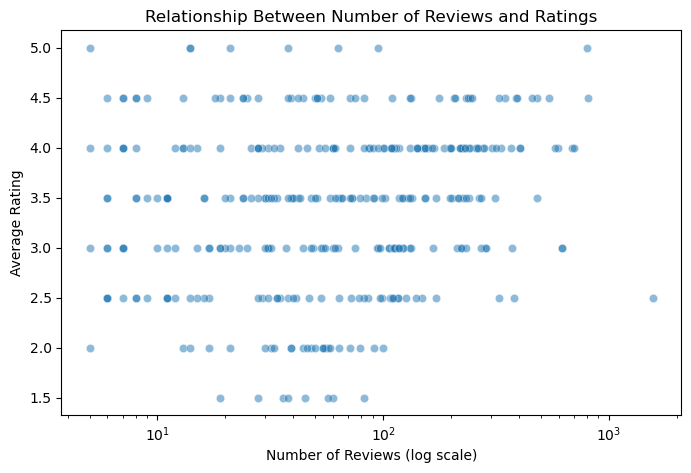

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_business, x="review_count", y="stars", alpha=0.5)
plt.xscale("log") 
plt.title("Relationship Between Number of Reviews and Ratings")
plt.xlabel("Number of Reviews (log scale)")
plt.ylabel("Average Rating")
plt.show()


/tmp/ipykernel_6341/137038013.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x="user_id", y="review_count", palette="Reds_d")


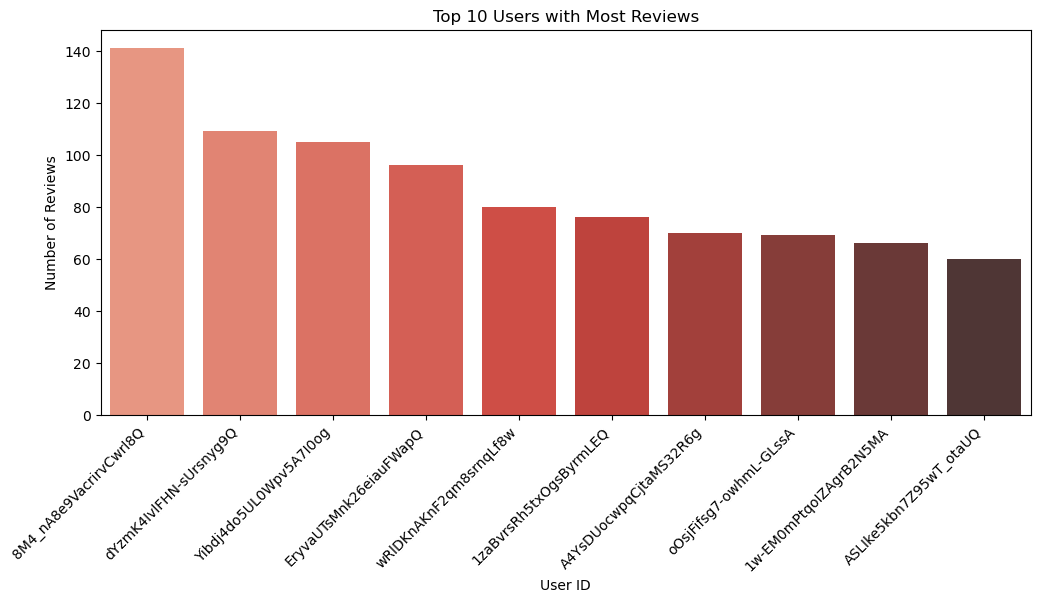

In [ ]:
user_review_counts = df_review["user_id"].value_counts()

df_user["review_count"] = df_user["user_id"].map(user_review_counts).fillna(0).astype(int)
top_users = df_user.nlargest(10, "review_count")

plt.figure(figsize=(12, 5))
sns.barplot(data=top_users, x="user_id", y="review_count", palette="Reds_d")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Users with Most Reviews")
plt.xlabel("User ID")
plt.ylabel("Number of Reviews")
plt.show()


/tmp/ipykernel_6341/375514905.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_review, x="sentiment", palette="Set1")


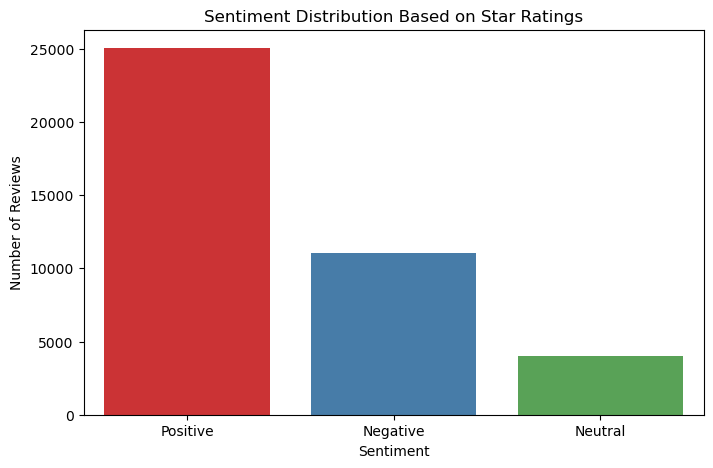

In [16]:
df_review["sentiment"] = df_review["stars"].apply(lambda x: "Positive" if x >= 4 else "Negative" if x <= 2 else "Neutral")

plt.figure(figsize=(8, 5))
sns.countplot(data=df_review, x="sentiment", palette="Set1")
plt.title("Sentiment Distribution Based on Star Ratings")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


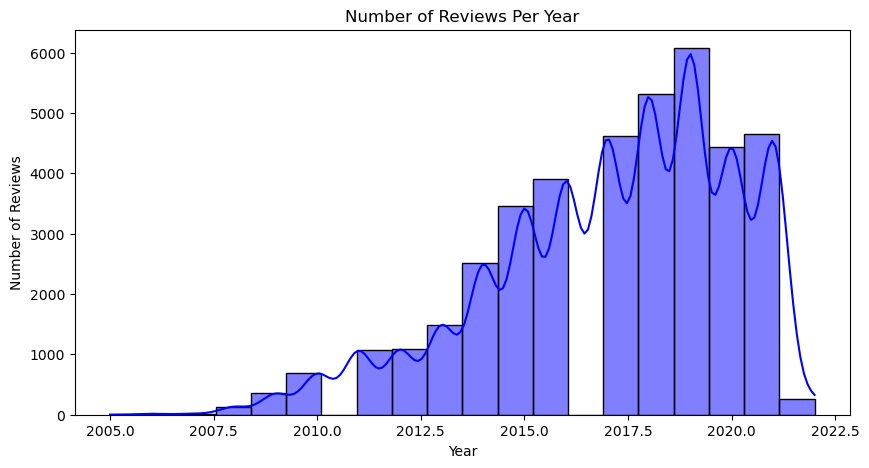

In [17]:
df_review["year"] = pd.to_datetime(df_review["date"]).dt.year

plt.figure(figsize=(10, 5))
sns.histplot(df_review["year"], bins=20, kde=True, color="blue")
plt.title("Number of Reviews Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.show()


## preprocessing

In [ ]:

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


def preprocess_text(text):
    text = text.lower().strip()

    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return " ".join(tokens)



In [ ]:
#tqdm.pandas(desc="Processing texts")
#df_review["clean_text"] = df_review["text"].progress_apply(preprocess_text)
#print("\nTexts processed!\n")



### Save preprocessed reviews


In [ ]:
# save processed data
#f_review.to_csv("data/processed_reviews.csv", index=False)
#df_business.to_csv("data/processed_business.csv", index=False)
#df_user.to_csv("data/processed_users.csv", index=False)
#print("\n Data saved!\n")


### Load the processed data


In [ ]:
df_review = pd.read_csv("data/processed_reviews.csv")
df_business = pd.read_csv("data/processed_business.csv")
df_user = pd.read_csv("data/processed_users.csv")
print("\n Data loaded!\n")


 Data loaded!



## Deep Sentiment Analysis 

### Using Roberta


In [ ]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
def get_sentiment_score(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0 

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = softmax(outputs.logits, dim=1)

    sentiment_score = probs[0][2].item() - probs[0][0].item()

    return sentiment_score


In [ ]:
def classify_sentiment(score):
    if score > 0.4:
        return "Positive"
    elif -0.4 < score < 0.4:
        return "Neutral"
    else:
        return "Negative"
df_review["sentiment"] = df_review["sentiment_score"].apply(classify_sentiment)


In [ ]:
df_review = pd.read_csv("data/processed_reviews_sentiment.csv")
print("\n Sentiment loaded!\n") 


 Sentiment loaded!



### nlptown/bert 

In [441]:
MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

In [442]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
model.eval()

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
def get_sentiment_score(text):
    if not isinstance(text, str) or text.strip() == "":
        return 3.0

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
    
    probs = softmax(outputs.logits, dim=1)
    
    probs_cpu = probs[0].cpu().numpy()

    sentiment_score = sum([(i + 1) * p for i, p in enumerate(probs_cpu)])

    return sentiment_score


In [444]:
def classify_sentiment(score, threshold_pos=3.8, threshold_neg=2.2):
    if score >= threshold_pos:
        return "Positive"
    elif score <= threshold_neg:
        return "Negative"
    else:
        return "Neutral"

In [445]:
tqdm.pandas() 
df_review["sentiment_score_2"] = df_review["text"].progress_apply(get_sentiment_score)

100%|██████████| 40101/40101 [14:59<00:00, 44.56it/s]


In [25]:
df_review["sentiment_2"] = df_review["sentiment_score_2"].apply(classify_sentiment)

### Resuls Roberta

### Results nlptown/bert 

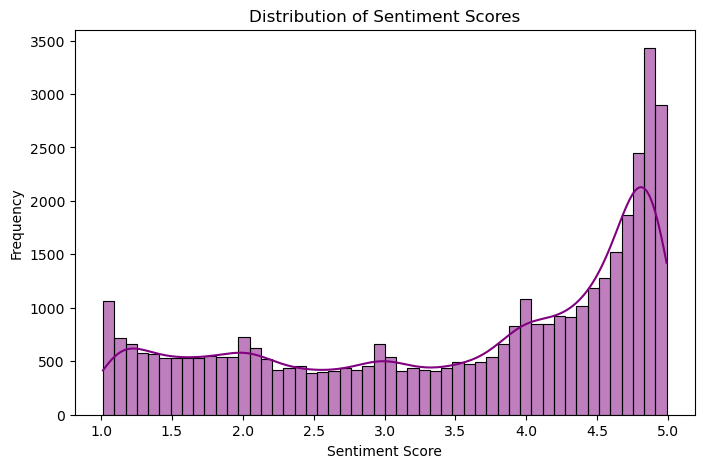

In [ ]:
df_review["sentiment_score_2"].describe()
plt.figure(figsize=(8, 5))
sns.histplot(df_review["sentiment_score_2"], bins=50, kde=True, color="purple")
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

In [ ]:
df_review["discrepancy_2"] = abs(df_review["stars"] - df_review["sentiment_score_2"])

print("Discrepancy between stars and sentiment score: ")
print("  < 1: ", round((len(df_review[df_review["discrepancy_2"] < 1]) / len(df_review) * 100),2), "%")
print("  1 to < 2: ", round((len(df_review[(df_review["discrepancy_2"] >= 1) & (df_review["discrepancy_2"] < 2)]) / len(df_review) * 100),2), "%")
print("  2 to < 3: ", round((len(df_review[(df_review["discrepancy_2"] >= 2) & (df_review["discrepancy_2"] < 3)]) / len(df_review) * 100),2), "%")
print("  3 to < 4: ", round((len(df_review[(df_review["discrepancy_2"] >= 3) & (df_review["discrepancy_2"] < 4)]) / len(df_review) * 100),2), "%")
print("  4 to < 5: ", round((len(df_review[(df_review["discrepancy_2"] >= 4) & (df_review["discrepancy_2"] < 5)]) / len(df_review) * 100),2), "%")


Discrepancy between stars and sentiment score: 
  < 1:  86.05 %
  1 to < 2:  11.72 %
  2 to < 3:  1.9 %
  3 to < 4:  0.34 %
  4 to < 5:  0.0 %


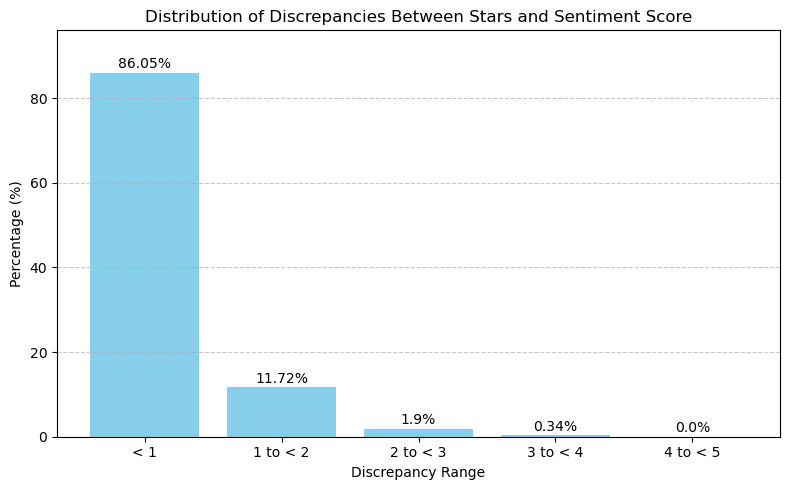

In [ ]:
categories = ["< 1", "1 to < 2", "2 to < 3", "3 to < 4", "4 to < 5"]
values = [
    round((len(df_review[df_review["discrepancy_2"] < 1]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy_2"] >= 1) & (df_review["discrepancy_2"] < 2)]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy_2"] >= 2) & (df_review["discrepancy_2"] < 3)]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy_2"] >= 3) & (df_review["discrepancy_2"] < 4)]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy_2"] >= 4) & (df_review["discrepancy_2"] < 5)]) / len(df_review) * 100), 2)
]

plt.figure(figsize=(8, 5))
plt.bar(categories, values, color='skyblue')
plt.xlabel("Discrepancy Range")
plt.ylabel("Percentage (%)")
plt.title("Distribution of Discrepancies Between Stars and Sentiment Score")
plt.ylim(0, max(values) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v}%", ha='center')

plt.tight_layout()
plt.show()

In [ ]:
rmse_stars_sentiment = sqrt(mean_squared_error(df_review["stars"], df_review["sentiment_score_2"]))
print("RMSE between stars and sentiment score: ", rmse_stars_sentiment)

mae_stars_sentiment = mean_absolute_error(df_review["stars"], df_review["sentiment_score_2"])
print("MAE between stars and sentiment score: ", mae_stars_sentiment)



RMSE between stars and sentiment score:  0.7413462766542119
MAE between stars and sentiment score:  0.5276396703310403


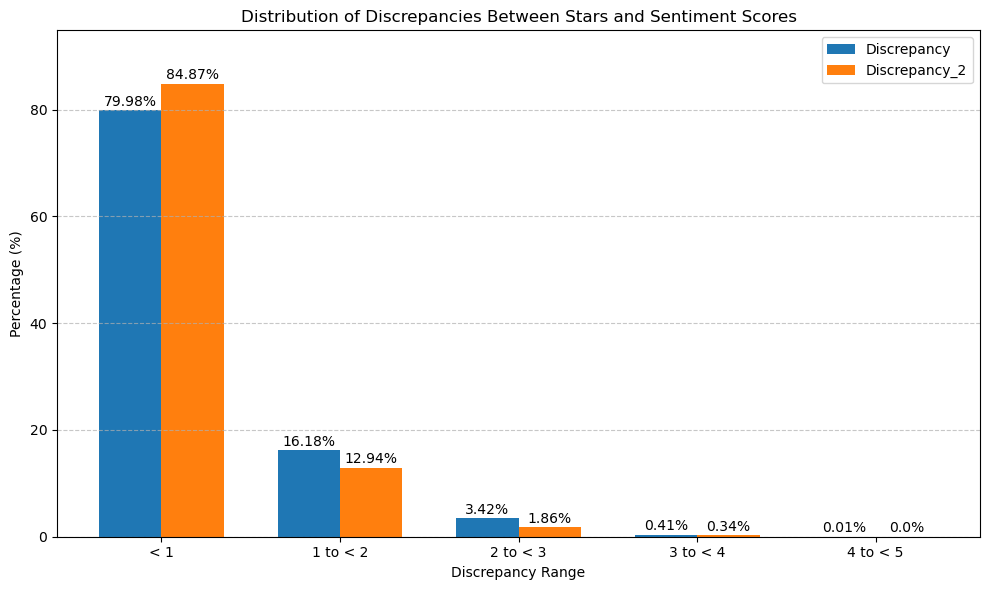

In [ ]:
categories = ["< 1", "1 to < 2", "2 to < 3", "3 to < 4", "4 to < 5"]

values_1 = [
    round((len(df_review[df_review["discrepancy"] < 1]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy"] >= 1) & (df_review["discrepancy"] < 2)]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy"] >= 2) & (df_review["discrepancy"] < 3)]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy"] >= 3) & (df_review["discrepancy"] < 4)]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy"] >= 4) & (df_review["discrepancy"] < 5)]) / len(df_review) * 100), 2)
]

values_2 = [
    round((len(df_review[df_review["discrepancy_2"] < 1]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy_2"] >= 1) & (df_review["discrepancy_2"] < 2)]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy_2"] >= 2) & (df_review["discrepancy_2"] < 3)]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy_2"] >= 3) & (df_review["discrepancy_2"] < 4)]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy_2"] >= 4) & (df_review["discrepancy_2"] < 5)]) / len(df_review) * 100), 2)
]

x = np.arange(len(categories)) 
width = 0.35 

plt.figure(figsize=(10,6))
plt.bar(x - width/2, values_1, width, label='Discrepancy')
plt.bar(x + width/2, values_2, width, label='Discrepancy_2')

plt.xlabel("Discrepancy Range")
plt.ylabel("Percentage (%)")
plt.title("Distribution of Discrepancies Between Stars and Sentiment Scores")
plt.xticks(x, categories)
plt.ylim(0, max(max(values_1), max(values_2)) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()


for i in range(len(categories)):
    plt.text(x[i] - width/2, values_1[i] + 0.8, f"{values_1[i]}%", ha='center')
    plt.text(x[i] + width/2, values_2[i] + 0.8, f"{values_2[i]}%", ha='center')

plt.tight_layout()
plt.show()


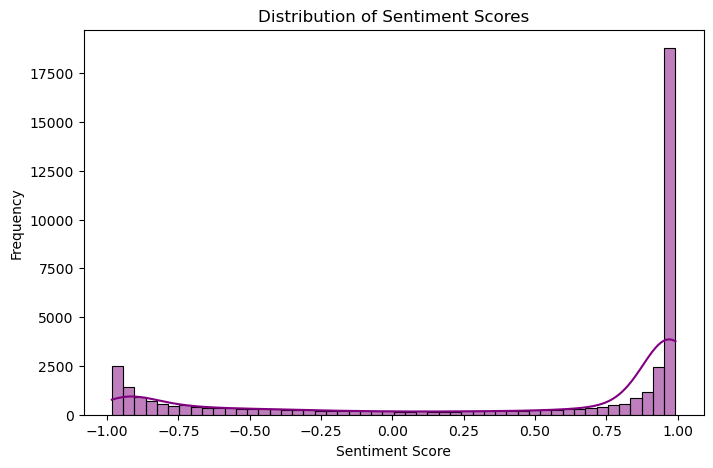

In [ ]:
df_review["sentiment_score"].describe()
plt.figure(figsize=(8, 5))
sns.histplot(df_review["sentiment_score"], bins=50, kde=True, color="purple")
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

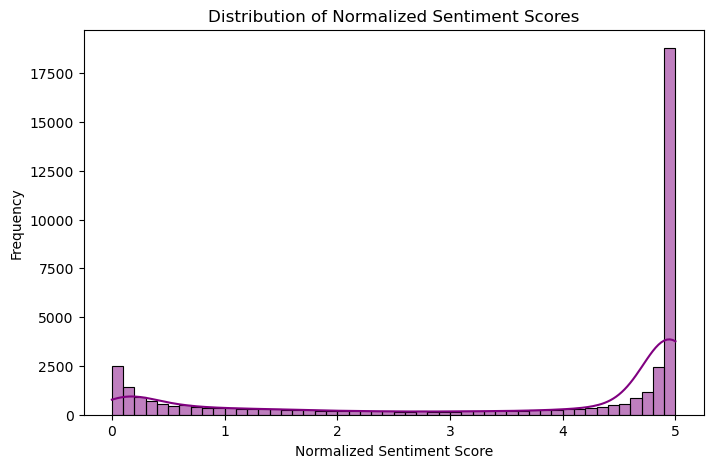

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 5))
df_review["sentiment_score"] = scaler.fit_transform(df_review[["sentiment_score"]])
plt.figure(figsize=(8, 5))
sns.histplot(df_review["sentiment_score"], bins=50, kde=True, color="purple")
plt.title("Distribution of Normalized Sentiment Scores")
plt.xlabel("Normalized Sentiment Score")
plt.ylabel("Frequency")
plt.show()

In [ ]:
df_review["discrepancy"] = abs(df_review["stars"] - df_review["sentiment_score"])

print("Discrepancy between stars and sentiment score: ")
print("  < 1: ", round((len(df_review[df_review["discrepancy"] < 1]) / len(df_review) * 100),2), "%")
print("  1 to < 2: ", round((len(df_review[(df_review["discrepancy"] >= 1) & (df_review["discrepancy"] < 2)]) / len(df_review) * 100),2), "%")
print("  2 to < 3: ", round((len(df_review[(df_review["discrepancy"] >= 2) & (df_review["discrepancy"] < 3)]) / len(df_review) * 100),2), "%")
print("  3 to < 4: ", round((len(df_review[(df_review["discrepancy"] >= 3) & (df_review["discrepancy"] < 4)]) / len(df_review) * 100),2), "%")
print("  4 to < 5: ", round((len(df_review[(df_review["discrepancy"] >= 4) & (df_review["discrepancy"] < 5)]) / len(df_review) * 100),2), "%")


Discrepancy between stars and sentiment score: 
  < 1:  83.62 %
  1 to < 2:  12.84 %
  2 to < 3:  2.95 %
  3 to < 4:  0.51 %
  4 to < 5:  0.09 %


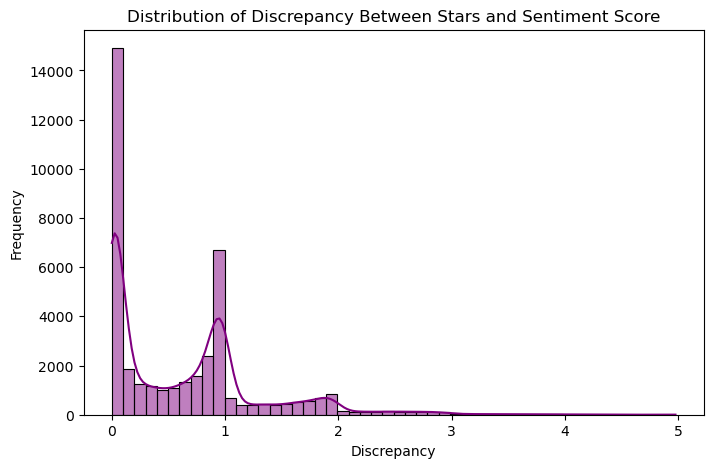

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_review["discrepancy"], bins=50, kde=True, color="purple")
plt.title("Distribution of Discrepancy Between Stars and Sentiment Score")
plt.xlabel("Discrepancy")
plt.ylabel("Frequency")
plt.show()      

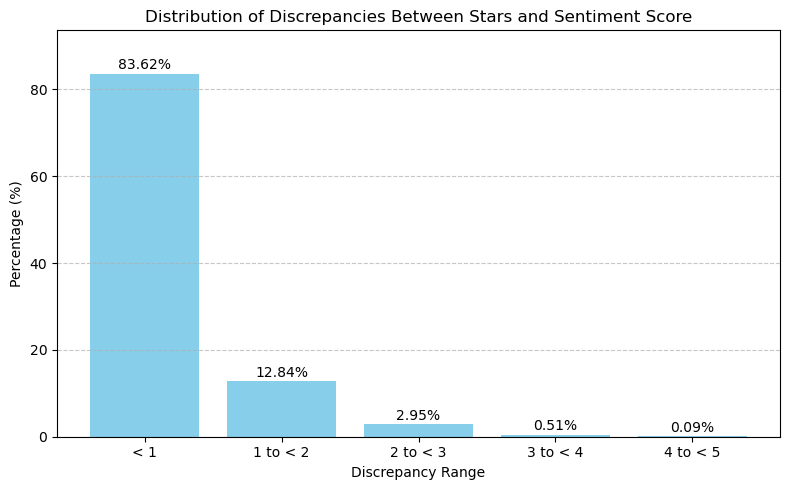

In [ ]:
categories = ["< 1", "1 to < 2", "2 to < 3", "3 to < 4", "4 to < 5"]
values = [
    round((len(df_review[df_review["discrepancy"] < 1]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy"] >= 1) & (df_review["discrepancy"] < 2)]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy"] >= 2) & (df_review["discrepancy"] < 3)]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy"] >= 3) & (df_review["discrepancy"] < 4)]) / len(df_review) * 100), 2),
    round((len(df_review[(df_review["discrepancy"] >= 4) & (df_review["discrepancy"] < 5)]) / len(df_review) * 100), 2)
]

plt.figure(figsize=(8, 5))
plt.bar(categories, values, color='skyblue')
plt.xlabel("Discrepancy Range")
plt.ylabel("Percentage (%)")
plt.title("Distribution of Discrepancies Between Stars and Sentiment Score")
plt.ylim(0, max(values) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v}%", ha='center')

plt.tight_layout()
plt.show()

In [ ]:
rmse_stars_sentiment = sqrt(mean_squared_error(df_review["stars"], df_review["sentiment_score"]))
print("RMSE between stars and sentiment score: ", rmse_stars_sentiment)
mae_stars_sentiment = mean_absolute_error(df_review["stars"], df_review["sentiment_score"])
print("MAE between stars and sentiment score: ", mae_stars_sentiment)



RMSE between stars and sentiment score:  0.9197220692416851
MAE between stars and sentiment score:  0.6224140809524035


/tmp/ipykernel_8585/2613134606.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_review, x="sentiment", palette="Set1")


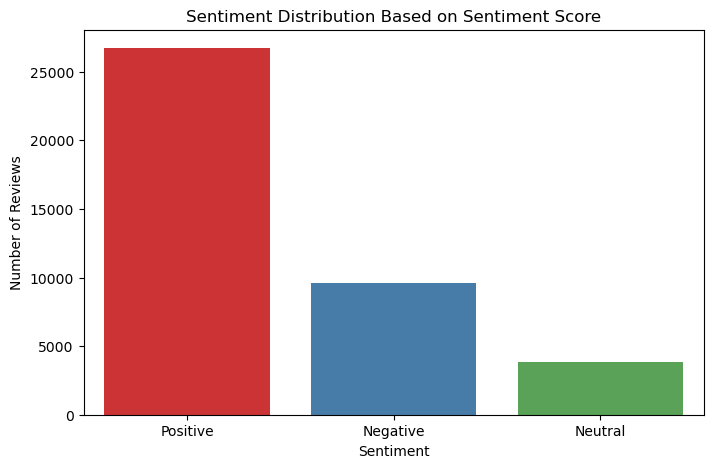

In [31]:
df_review["sentiment"].value_counts()
plt.figure(figsize=(8, 5))
sns.countplot(data=df_review, x="sentiment", palette="Set1")
plt.title("Sentiment Distribution Based on Sentiment Score")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

In [ ]:
df_review["sentiment_stars"] = df_review["stars"].apply(lambda x: "Positive" if x >= 4 else "Negative" if x <= 2 else "Neutral")
df_review["match"] = df_review["sentiment"] == df_review["sentiment_stars"]
accuracy = df_review["match"].mean()
print(f"Accuracy BERT model vs Stars: {accuracy:.2%}")



Accuracy BERT model vs Stars: 84.62%


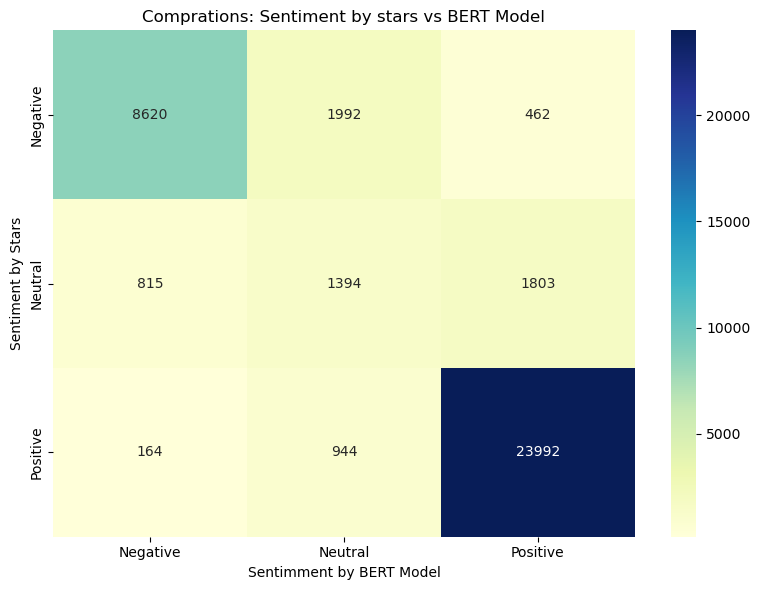

In [ ]:
conf_mat = pd.crosstab(df_review["sentiment_stars"], df_review["sentiment"])

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Comprations: Sentiment by stars vs BERT Model")
plt.xlabel("Sentimment by BERT Model")
plt.ylabel("Sentiment by Stars")
plt.tight_layout()
plt.show()


## Regression model (polinomial)

In [ ]:
X = df_review[["sentiment_score_2"]].values
y = df_review["stars"].values

In [ ]:
degrees = range(1, 30)
rmse_cv = []
mae_cv = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    
    neg_mse = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    rmse = np.mean(np.sqrt(-neg_mse)) 
    rmse_cv.append(rmse)
    
    neg_mae = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    mae = -neg_mae 
    mae_cv.append(np.mean(mae))

In [ ]:
best_degree = degrees[np.argmin(rmse_cv)]
print(f"Melhor grau encontrado: {best_degree}")


In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(degrees, rmse_cv, marker='o', color='blue')
plt.title("RMSE by Polynomial Degree (5-Fold CV)")
plt.xlabel("Polynomial Degree")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(degrees, mae_cv, marker='s', color='green')
plt.title("MAE by Polynomial Degree (5-Fold CV)")
plt.xlabel("Polynomial Degree")
plt.ylabel("MAE")
plt.grid(True)
plt.tight_layout()
plt.show()

## UBCF 

keep the last review from the user to a specific restaurant 

In [483]:
df_review["combined_score"] =  0 * df_review["stars"] + 1 * df_review["sentiment_score_2"]


In [ ]:
df_review = df_review[df_review["user_id"].isin(df_user[df_user["review_count"] >= 10]["user_id"])]


In [485]:
df_review = df_review.sort_values("date").drop_duplicates(subset=["user_id", "business_id"], keep="last")

In [486]:


user_restaurant_matrix = df_review.pivot(index="user_id", columns="business_id", values="combined_score")


In [487]:
user_restaurant_matrix = user_restaurant_matrix.fillna(0)

In [488]:
user_similarity = cosine_similarity(user_restaurant_matrix)

In [489]:
user_similarity_df = pd.DataFrame(user_similarity, index=user_restaurant_matrix.index, columns=user_restaurant_matrix.index)

In [453]:
df_business.shape

(334, 14)

In [490]:
df_review["combined_score"].describe()


count    7751.000000
mean        3.578929
std         1.086851
min         1.014370
25%         2.798929
50%         3.886217
75%         4.511964
max         4.984542
Name: combined_score, dtype: float64

In [491]:
user_similarity = cosine_similarity(user_restaurant_matrix)

In [492]:
user_similarity_df = pd.DataFrame(user_similarity, index=user_restaurant_matrix.index, columns=user_restaurant_matrix.index)

In [493]:
sparsity = 1.0 - (np.count_nonzero(user_restaurant_matrix) / float(user_restaurant_matrix.size))
print(f"Sparsity: {sparsity:.2%}")


Sparsity: 94.74%


**predict_rating** fucntion predicts the rating a user would give a restaurant based on the nearest neighbors

In [ ]:
def predict_rating(user_id, business_id, k=5):
    
    if business_id not in user_restaurant_matrix.columns:
        return 0  
    
    users_who_rated = user_restaurant_matrix[business_id][user_restaurant_matrix[business_id] > 0].index

    users_who_rated = users_who_rated.difference([user_id])

    similarities = user_similarity_df[user_id].loc[users_who_rated]
    
    top_neighbors = similarities.nlargest(k)
    
    neighbor_ratings = user_restaurant_matrix.loc[top_neighbors.index, business_id]
    # ex (4.0×0.9)+(3.5×0.8)=3.6+2.8=6.4
    # 0.9+0.8=1.7

    if top_neighbors.sum() > 0:
        predicted_rating = np.dot(neighbor_ratings, top_neighbors) / top_neighbors.sum()
    else:
        predicted_rating = 0  
    
    return predicted_rating


#### Evaluation

In [495]:
df_test = df_review.sample(frac=0.2, random_state=42)  
df_train = df_review.drop(df_test.index)

user_restaurant_matrix_train = df_train.pivot(index="user_id", columns="business_id", values="combined_score").fillna(0)

In [496]:
true_ratings = []
pred_ratings = []

for _, row in df_test.iterrows():
    user_id = row["user_id"]
    business_id = row["business_id"]
    true_rating = row["stars"]
    
    pred_rating = predict_rating(user_id, business_id, k=5)
    
    true_ratings.append(true_rating)
    pred_ratings.append(pred_rating)

rmse = sqrt(mean_squared_error(true_ratings, pred_ratings))
print(f" RMSE: {rmse:.4f}")

mae = mean_absolute_error(true_ratings, pred_ratings)
print(f" MAE: {mae:.4f}")

 RMSE: 1.2285
 MAE: 0.9846


#### Recommender system


In [523]:
def recommend_user_cf(user_id, top_n=5, include_seen=True):
    if include_seen:
        restaurants = user_restaurant_matrix.columns
    else:
        restaurants = user_restaurant_matrix.columns[user_restaurant_matrix.loc[user_id] == 0]
    recommendations = []

    for business_id in restaurants:
        predicted_rating = predict_rating(user_id, business_id)
        recommendations.append((business_id, predicted_rating))
    
    recommendations.sort(key=lambda x: x[1], reverse=True)
    
    return recommendations[:top_n]

In [ ]:
df_user.shape

(20175, 22)

## IBCF

In [500]:
item_similarity = cosine_similarity(user_restaurant_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_restaurant_matrix.columns, columns=user_restaurant_matrix.columns)

In [501]:
def predict_rating_ibcf(user_id, business_id, k=5, matrix=user_restaurant_matrix, similarity=item_similarity_df):
    if user_id not in matrix.index or business_id not in matrix.columns:
        return matrix.stack().mean()  

    user_ratings = matrix.loc[user_id]
    rated_items = user_ratings[user_ratings > 0]

    if rated_items.empty:
        return matrix[business_id].mean()  

    similarities = similarity.loc[business_id, rated_items.index]

    top_k_similar = similarities.nlargest(k)
    top_k_ratings = rated_items[top_k_similar.index]

    if top_k_similar.sum() > 0:
        predicted_rating = np.dot(top_k_ratings, top_k_similar) / top_k_similar.sum()
    else:
        predicted_rating = rated_items.mean()  

    return np.clip(predicted_rating, 1.0, 5.0)

In [502]:
true_ratings = []
pred_ratings = []

for _, row in df_test.iterrows():
    user_id = row["user_id"]
    business_id = row["business_id"]
    true_rating = row["stars"]

    pred = predict_rating_ibcf(user_id, business_id)
    true_ratings.append(true_rating)
    pred_ratings.append(pred)

rmse = sqrt(mean_squared_error(true_ratings, pred_ratings))
mae = mean_absolute_error(true_ratings, pred_ratings)

print(f"Item-based CF → RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Item-based CF → RMSE: 0.8972, MAE: 0.7191


In [ ]:
def recommend_user_ibcf(user_id, top_n=5):
    unrated_restaurants = user_restaurant_matrix.columns[user_restaurant_matrix.loc[user_id] == 0]

    predictions = []
    for business_id in unrated_restaurants:
        pred = predict_rating_ibcf(user_id, business_id)
        predictions.append((business_id, pred))

    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:top_n]

In [ ]:
user_id = df_review["user_id"].sample().iloc[0]
recommend_user_ibcf(user_id, top_n=20)  

[('-kGUmgyeYcNDcuEr4FoVeA', 5.0),
 ('0zm9uI875WIPX99D7xmIKA', 5.0),
 ('9bh2bRGo_FQZmZciQHqYJw', 5.0),
 ('DSYVbqvHETkd_DWvmYxPXQ', 5.0),
 ('WTrmBvsI65Zk5SvRweNZkw', 5.0),
 ('j-R5Rrink9LxUta6PC9iFw', 5.0),
 ('qKnEaOZAsjRT0Xp-Epktcw', 5.0),
 ('ybx2VuDMozpPGU_yUd35tQ', 5.0),
 ('zmeoe9VJ7vIVK-yO1GZTiw', 5.0),
 ('4D19uG4enigRAsvTVmn61g', 4.999999999999999),
 ('WAFpImG-SsFcZ96ILCopYg', 4.999999999999999),
 ('2E5fh57OvOQMWwxxEOkN8A', 4.853696235323308),
 ('3kNwvKixMwe44dWvQd5PAQ', 4.747514814431048),
 ('sSY87quBd3LjV5Rk-KcPPw', 4.724196965386551),
 ('dLbQ8vOVpAJNjYLM1a3yJA', 4.705244906298645),
 ('mS-ZtRREi7rhTL5Cg8VEvg', 4.594386436798226),
 ('sGLDJ4V4ezZZemFHCa0z_g', 4.55441353039685),
 ('aOVSb6B6DlqVaBJ04dmPxQ', 4.54996439582064),
 ('qvqX_8btlzurBskIMpVtmw', 4.5271782807594185),
 ('v3eo7Et1D70AXumFLzgcNA', 4.511830212776531)]

# **Part2**

## **Social Network Analysis**

Restaurante escolhido: ve_-rPlEGPClytyJtY55Vw
Total de reviews positivas: 395
Total de users com reviews positivas: 383
Total de users com amigos: 383
Total de redes de amigos: 316
Número total de nós: 384
Número total de arestas: 603
Peso máximo: 4


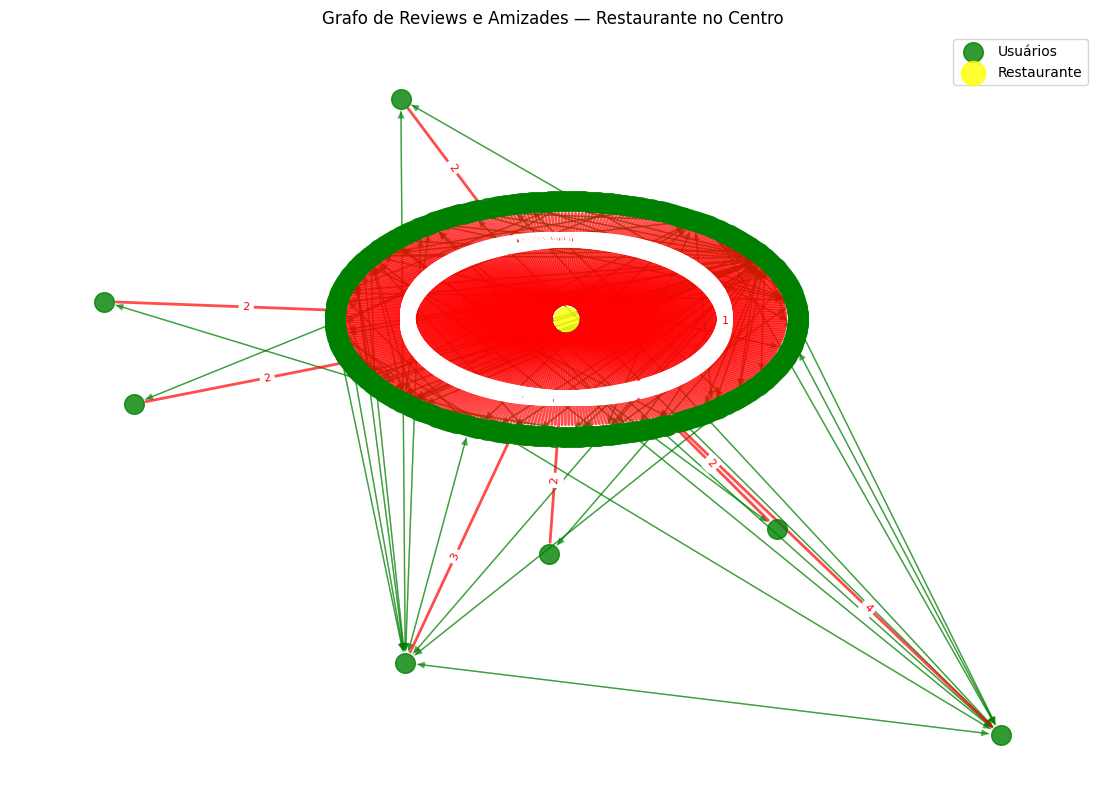

In [10]:
positive_reviews = df_review[df_review['stars'] >= 4]
review_counts = positive_reviews['business_id'].value_counts()
top_n = 10  

if len(review_counts) >= top_n:
    chosen_restaurant_id = review_counts.index[top_n - 1]
    print(f"Restaurante escolhido: {chosen_restaurant_id}")
    print(f"Total de reviews positivas: {review_counts[chosen_restaurant_id]}")
else:
    raise ValueError("Número insuficiente de restaurantes com reviews positivas.")

rest_reviews = positive_reviews[positive_reviews['business_id'] == chosen_restaurant_id].copy()
rest_reviews['date'] = pd.to_datetime(rest_reviews['date'])
rest_reviews = rest_reviews.sort_values(by='date')
review_users = set(rest_reviews['user_id']) 
print(f"Total de users com reviews positivas: {len(review_users)}")

user_friends = {
    user['user_id']: set(user['friends'].split(', ')) & review_users
    for _, user in df_user[df_user['user_id'].isin(review_users)].iterrows()
}
print(f"Total de users com amigos: {len(user_friends)}")

friendship_graph = nx.Graph()
for user, friends in user_friends.items():
    friendship_graph.add_node(user)
    for friend in friends:
        friendship_graph.add_edge(user, friend)

friend_networks = list(nx.connected_components(friendship_graph))
print(f"Total de redes de amigos: {len(friend_networks)}")

G = nx.DiGraph()
G.add_node(chosen_restaurant_id, type='restaurant')

for user in review_users:
    G.add_node(user, type='user')

for user, friends in user_friends.items():
    for friend in friends:
        if friend in review_users:
            G.add_edge(user, friend, weight=0)
            G.add_edge(friend, user, weight=0)

user_review_dates = dict(zip(rest_reviews['user_id'], rest_reviews['date']))
user_weights = {}

for network in friend_networks:
    network = network & review_users
    if not network:
        continue
    network_reviews = rest_reviews[rest_reviews['user_id'].isin(network)]
    if not network_reviews.empty:
        network_reviews = network_reviews.sort_values(by='date')
        first_user = network_reviews.iloc[0]['user_id']
        user_weights[first_user] = 1
        G.add_edge(first_user, chosen_restaurant_id, weight=1)
        
        queue = deque([(first_user, 1)])
        visited = {first_user}
        
        while queue:
            current_user, current_weight = queue.popleft()
            current_date = user_review_dates[current_user]
            
            for friend in user_friends.get(current_user, []) & network:
                if friend not in visited:
                    friend_date = user_review_dates.get(friend)
                    if friend_date and friend_date > current_date:
                        friend_weights = [
                            user_weights[neighbor]
                            for neighbor in user_friends.get(friend, []) & visited
                        ]
                        if friend_weights:
                            min_weight = min(friend_weights)
                            user_weights[friend] = min_weight + 1
                        else:
                            user_weights[friend] = current_weight + 1
                        G.add_edge(friend, chosen_restaurant_id, weight=user_weights[friend])
                        visited.add(friend)
                        queue.append((friend, user_weights[friend]))
                elif friend in user_weights:
                    friend_weights = [
                        user_weights[neighbor]
                        for neighbor in user_friends.get(friend, []) & visited
                    ]
                    if friend_weights:
                        new_weight = min(friend_weights) + 1
                        if new_weight < user_weights[friend]:
                            user_weights[friend] = new_weight
                            G.remove_edge(friend, chosen_restaurant_id)
                            G.add_edge(friend, chosen_restaurant_id, weight=new_weight)

for user in review_users:
    if user not in user_weights:
        user_weights[user] = 1
        G.add_edge(user, chosen_restaurant_id, weight=1)

print(f"Número total de nós: {G.number_of_nodes()}")
print(f"Número total de arestas: {G.number_of_edges()}")

users = [n for n, d in G.nodes(data=True) if d['type'] == 'user']
n_users = len(users)

pos = {chosen_restaurant_id: np.array([0.0, 0.0])}

circle_radius = 10
angle_step = 2 * np.pi / n_users

weights = {}
max_weight = 1
for u in users:
    if G.has_edge(u, chosen_restaurant_id):
        w = G[u][chosen_restaurant_id]['weight']
        weights[u] = w
        if w > max_weight:
            max_weight = w
print(f"Peso máximo: {max_weight}")

max_radius_factor = 3
for i, user in enumerate(users):
    angle = i * angle_step
    w = weights[user]
    radius = circle_radius * (w / max_weight) * max_radius_factor
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    pos[user] = np.array([x, y])

plt.figure(figsize=(14, 10))
friendship_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] == 0]
review_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] != 0]

nx.draw_networkx_nodes(G, pos, nodelist=users, node_color='green', node_size=200, alpha=0.8, label='Usuários')
nx.draw_networkx_nodes(G, pos, nodelist=[chosen_restaurant_id], node_color='yellow', node_size=300, alpha=0.8, label='Restaurante')

'''labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_color='black')'''

nx.draw_networkx_edges(G, pos, edgelist=friendship_edges, edge_color='green', width=1.0, alpha=0.5, label='Amizades')
nx.draw_networkx_edges(G, pos, edgelist=review_edges, edge_color='red', width=2.0, alpha=0.7, label='Reviews')

edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True) if d['weight'] != 0}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8, label_pos=0.3)

plt.legend(scatterpoints=1, loc='upper right')
plt.title("Grafo de Reviews e Amizades — Restaurante no Centro")
plt.axis('off')
plt.show()

### **Graph Characteristics**

#### Graph sorted by degree

In [11]:
sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
sorted_nodes

[('ve_-rPlEGPClytyJtY55Vw', 383),
 ('vHc-UrI9yfL_pnnc6nJtyQ', 79),
 ('M5HoGdy-mNOV7EHhxB9P9A', 27),
 ('_Wkf2RNDnBuqMOpzSqmZXw', 25),
 ('Lu8y2ayxVlAzuJEVfVcH4w', 21),
 ('M6GhCo2b6PjirUSLb0IgZg', 19),
 ('R9IJ1Byr27n6wXj3QvJ2Lg', 13),
 ('2l0O1EI1m0yWjFo2zSt71w', 13),
 ('B7laWmiMZHgsxiHk2U9H9A', 11),
 ('87S0AGlgY7HDU_KkTbMHHQ', 11),
 ('dYzmK4IvlFHN-sUrsnyg9Q', 11),
 ('MWLQEpkjLqjst7dO8TeEwQ', 11),
 ('hoFp0sSzAB5e_ekzOeHHHQ', 9),
 ('tO-BeTQAlIWrgtzYPKCVHA', 9),
 ('xMYdgaWjAvVFej72f4qHxw', 9),
 ('tgeFUChlh7v8bZFVl2-hjQ', 9),
 ('2zw5pNWAyn0vXxAylutJtg', 7),
 ('3XzhO2aJdvVtYhKOCJsPrg', 7),
 ('ub9gpClegbi7u0QEa7499g', 7),
 ('rNm9bItfqHT4Y2_tXsjL2Q', 7),
 ('m5nb4WNYldQpWd3ZEr05BQ', 7),
 ('1dQiuUvvK8427TBmqj_4Vg', 7),
 ('s6MvJ-hsyzSmSkzG8VeQQw', 5),
 ('5DXBSM2uhmzHW-HTOwjkeA', 5),
 ('zgFpxIm2_I86lhtHOdmjsQ', 5),
 ('nQyKR-5Tw2bM63P6_ClesA', 5),
 ('khk-xOwzgLYn0o2u3pwTTQ', 5),
 ('DEne4NSGx1yunoiekck2Qg', 5),
 ('0A-Gsndh33HhYLE42hIjEQ', 5),
 ('0W72fMBO91kJFh9MVrTbIA', 5),
 ('Mj5f9C-rVEuMDgmMW3Zm3w',

#### Density

The density of a graph is a measure of how close it is to being fully connected.

In [12]:
density = nx.density(G)
print(f"Density: {density:0.4f}")

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
possible_edges = num_nodes * (num_nodes - 1) 

manual_density = num_edges / possible_edges

Density: 0.0041


#### Diameter 

How far apart the most distant pair of connected nodes are in terms of social or review connection.

In [13]:
if nx.is_strongly_connected(G):
    diameter = nx.diameter(G)
    print(f"Diameter of the graph: {diameter}")
else:
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    G_scc = G.subgraph(largest_scc).copy()
    diameter = nx.diameter(G_scc)
    print(f"Diameter of the largest strongly connected component: {diameter}")


Diameter of the largest strongly connected component: 7


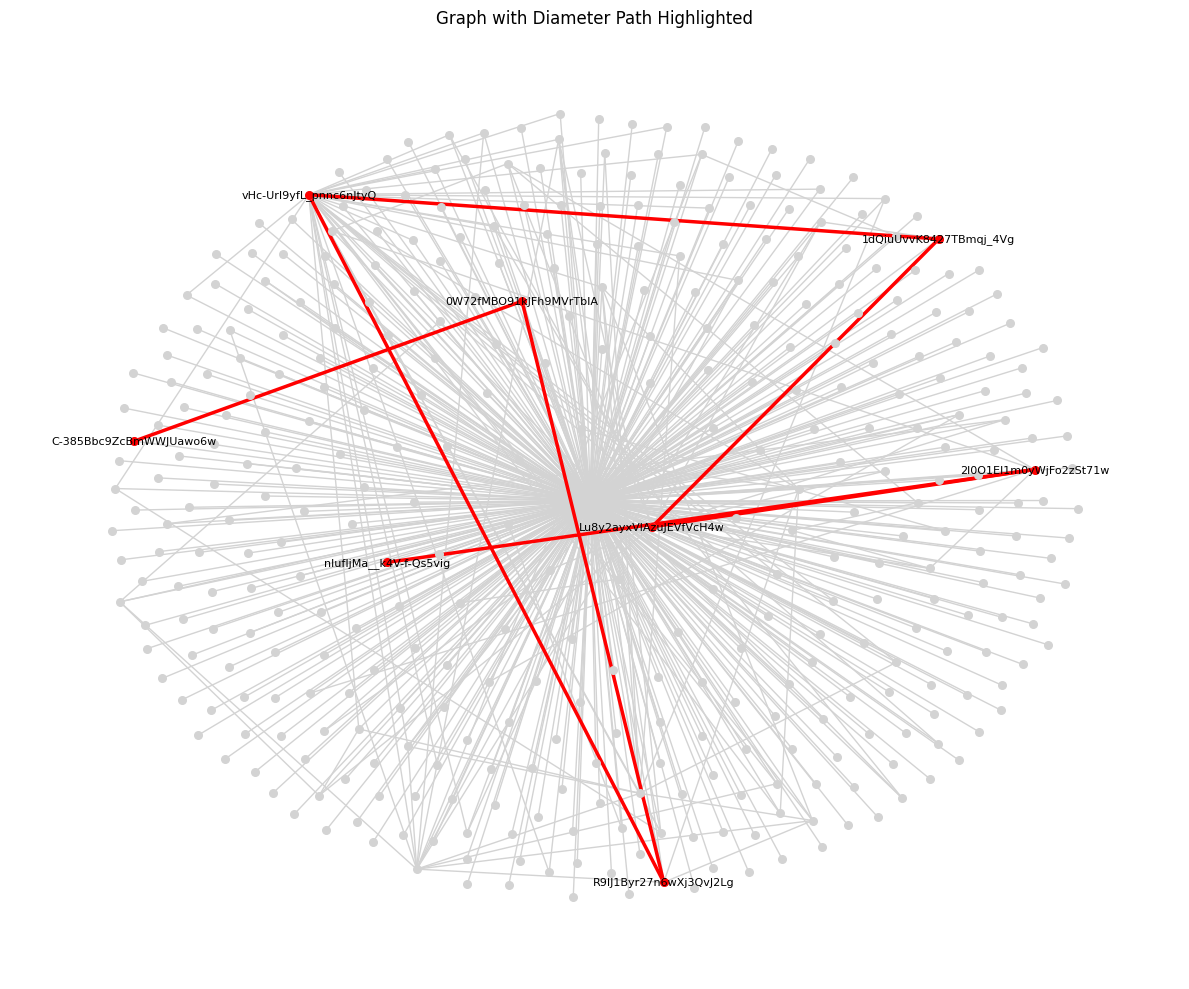

In [14]:
G_undirected = G.to_undirected()
diameter_length = nx.diameter(G_undirected)

lengths = dict(nx.all_pairs_shortest_path_length(G_undirected))
from networkx.algorithms.shortest_paths.generic import shortest_path

for u in G.nodes():
    lengths = nx.single_source_shortest_path_length(G, u)
    for v, d in lengths.items():
        if d == diameter:
            node_pair = (u, v)
            break
    else:
        continue
    break


diameter_path = shortest_path(G, source=node_pair[0], target=node_pair[1])
diameter_edges = list(zip(diameter_path[:-1], diameter_path[1:]))

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_undirected, seed=42)

nx.draw_networkx_nodes(G_undirected, pos, node_color='lightgray', node_size=30)
nx.draw_networkx_edges(G_undirected, pos, edge_color='lightgray', width=1.0)
nx.draw_networkx_edges(G_undirected, pos, edgelist=diameter_edges, edge_color='red', width=2.5)
nx.draw_networkx_nodes(G, pos, nodelist=diameter_path, node_color="red", node_size=30)
nx.draw_networkx_labels(G_undirected, pos, labels={node: node for node in diameter_path}, font_size=8)

plt.title("Graph with Diameter Path Highlighted")
plt.axis('off')
plt.tight_layout()
plt.show()


In the most connected cluster, the farthest any user is from the restaurant (or another user) is 7 steps away, following the influence/review direction.

#### Node degrees

In [15]:
degree_dict = dict(G.degree())
in_degree_dict = dict(G.in_degree())
out_degree_dict = dict(G.out_degree())


In [16]:
top_degrees = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by total degree:")
for node, deg in top_degrees:
    print(f"{node}: {deg}")


Top 10 nodes by total degree:
ve_-rPlEGPClytyJtY55Vw: 383
vHc-UrI9yfL_pnnc6nJtyQ: 79
M5HoGdy-mNOV7EHhxB9P9A: 27
_Wkf2RNDnBuqMOpzSqmZXw: 25
Lu8y2ayxVlAzuJEVfVcH4w: 21
M6GhCo2b6PjirUSLb0IgZg: 19
R9IJ1Byr27n6wXj3QvJ2Lg: 13
2l0O1EI1m0yWjFo2zSt71w: 13
B7laWmiMZHgsxiHk2U9H9A: 11
87S0AGlgY7HDU_KkTbMHHQ: 11


In [17]:
print("Top 10 by in-degree:")
print(sorted(in_degree_dict.items(), key=lambda x: x[1], reverse=True)[:10])

print("Top 10 by out-degree:")
print(sorted(out_degree_dict.items(), key=lambda x: x[1], reverse=True)[:10])


Top 10 by in-degree:
[('ve_-rPlEGPClytyJtY55Vw', 383), ('vHc-UrI9yfL_pnnc6nJtyQ', 39), ('M5HoGdy-mNOV7EHhxB9P9A', 13), ('_Wkf2RNDnBuqMOpzSqmZXw', 12), ('Lu8y2ayxVlAzuJEVfVcH4w', 10), ('M6GhCo2b6PjirUSLb0IgZg', 9), ('R9IJ1Byr27n6wXj3QvJ2Lg', 6), ('2l0O1EI1m0yWjFo2zSt71w', 6), ('B7laWmiMZHgsxiHk2U9H9A', 5), ('87S0AGlgY7HDU_KkTbMHHQ', 5)]
Top 10 by out-degree:
[('vHc-UrI9yfL_pnnc6nJtyQ', 40), ('M5HoGdy-mNOV7EHhxB9P9A', 14), ('_Wkf2RNDnBuqMOpzSqmZXw', 13), ('Lu8y2ayxVlAzuJEVfVcH4w', 11), ('M6GhCo2b6PjirUSLb0IgZg', 10), ('R9IJ1Byr27n6wXj3QvJ2Lg', 7), ('2l0O1EI1m0yWjFo2zSt71w', 7), ('B7laWmiMZHgsxiHk2U9H9A', 6), ('87S0AGlgY7HDU_KkTbMHHQ', 6), ('dYzmK4IvlFHN-sUrsnyg9Q', 6)]


Users:
- High out-degree → they have many outgoing edges (e.g., friendships and reviews).
- High in-degree → many users added them as friends (if friendships are mutual, both).

Restaurant node:
- High in-degree → many users reviewed it (each review is an edge pointing to it).
- Out-degree should be 0 (it doesn't connect to anyone).

#### Closeness

Closeness centrality of a node measures how close it is to all other nodes, based on the shortest paths.

In [18]:
closeness = nx.closeness_centrality(G)

top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)#[:10]
print("Top 10 nodes by closeness centrality:")
for node, value in top_closeness:
    print(f"{node}: {value:.4f}")

Top 10 nodes by closeness centrality:
ve_-rPlEGPClytyJtY55Vw: 1.0000
vHc-UrI9yfL_pnnc6nJtyQ: 0.0925
M5HoGdy-mNOV7EHhxB9P9A: 0.0768
M6GhCo2b6PjirUSLb0IgZg: 0.0756
1dQiuUvvK8427TBmqj_4Vg: 0.0725
B7laWmiMZHgsxiHk2U9H9A: 0.0705
tO-BeTQAlIWrgtzYPKCVHA: 0.0691
ub9gpClegbi7u0QEa7499g: 0.0682
87S0AGlgY7HDU_KkTbMHHQ: 0.0673
_Wkf2RNDnBuqMOpzSqmZXw: 0.0669
Lu8y2ayxVlAzuJEVfVcH4w: 0.0664
nQyKR-5Tw2bM63P6_ClesA: 0.0652
GHoBAN6v5zprtUeOi4iicg: 0.0652
by81q_rpwwMStxhfOhZFwQ: 0.0652
sfLTjzc1ceEpzZRnXz512Q: 0.0652
R9IJ1Byr27n6wXj3QvJ2Lg: 0.0648
MWLQEpkjLqjst7dO8TeEwQ: 0.0644
2zw5pNWAyn0vXxAylutJtg: 0.0628
rNm9bItfqHT4Y2_tXsjL2Q: 0.0624
s6MvJ-hsyzSmSkzG8VeQQw: 0.0621
0A-Gsndh33HhYLE42hIjEQ: 0.0621
jv0KSBZkHoojy6RkIc5SIw: 0.0621
dYzmK4IvlFHN-sUrsnyg9Q: 0.0613
hoFp0sSzAB5e_ekzOeHHHQ: 0.0610
khk-xOwzgLYn0o2u3pwTTQ: 0.0602
3XzhO2aJdvVtYhKOCJsPrg: 0.0602
vjfi0yDfkRX3pLkiW5WT9A: 0.0602
56QSLA3M13Xk1YQ0pXa5tg: 0.0602
5DXBSM2uhmzHW-HTOwjkeA: 0.0599
1XM9mue9DS16xxlsrRNawA: 0.0599
jtMvQzQWeDQIX32EFs91gQ: 0.0599
f

Users with high closeness are well-positioned to reach or influence others efficiently in the network (via friendship).

#### Betweeness

Betweenness centrality measures how often a node lies on the shortest paths between other nodes.

In [19]:
betweenness = nx.betweenness_centrality(G)

top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)#[:10]
print("Top 10 nodes by betweenness centrality:")
for node, value in top_betweenness:
    print(f"{node}: {value:.4f}")

Top 10 nodes by betweenness centrality:
vHc-UrI9yfL_pnnc6nJtyQ: 0.0172
Lu8y2ayxVlAzuJEVfVcH4w: 0.0097
M6GhCo2b6PjirUSLb0IgZg: 0.0046
M5HoGdy-mNOV7EHhxB9P9A: 0.0043
1dQiuUvvK8427TBmqj_4Vg: 0.0027
tgeFUChlh7v8bZFVl2-hjQ: 0.0026
2l0O1EI1m0yWjFo2zSt71w: 0.0021
R9IJ1Byr27n6wXj3QvJ2Lg: 0.0017
_Wkf2RNDnBuqMOpzSqmZXw: 0.0013
xMYdgaWjAvVFej72f4qHxw: 0.0012
3XzhO2aJdvVtYhKOCJsPrg: 0.0011
2zw5pNWAyn0vXxAylutJtg: 0.0009
zgFpxIm2_I86lhtHOdmjsQ: 0.0008
0W72fMBO91kJFh9MVrTbIA: 0.0008
Mj5f9C-rVEuMDgmMW3Zm3w: 0.0008
MNLPwQUL2ua0XjXtD6AuEw: 0.0008
m5nb4WNYldQpWd3ZEr05BQ: 0.0008
ub9gpClegbi7u0QEa7499g: 0.0005
87S0AGlgY7HDU_KkTbMHHQ: 0.0003
B7laWmiMZHgsxiHk2U9H9A: 0.0002
tO-BeTQAlIWrgtzYPKCVHA: 0.0001
MWLQEpkjLqjst7dO8TeEwQ: 0.0001
rNm9bItfqHT4Y2_tXsjL2Q: 0.0000
dYzmK4IvlFHN-sUrsnyg9Q: 0.0000
hoFp0sSzAB5e_ekzOeHHHQ: 0.0000
klXtHEpnfPE_67OflnQTmg: 0.0000
p9eFxyrE6QmgI3KgIDh5Jg: 0.0000
ve_-rPlEGPClytyJtY55Vw: 0.0000
8IR5OVgcOlLmlIhaGD40ug: 0.0000
WfZFj0OH9tuOdxEfSaM1vA: 0.0000
KT9ts6NpEybWGHFNRBXjzA: 0.0000

- High betweenness → node controls communication between others (acts as a gatekeeper).
- These users might be influential connectors between friend groups or temporal review chains.
- If the restaurant node has only incoming edges, its betweenness will likely be 0 — it's a sink, not a bridge.

#### Average Path Length

The average path length is the mean number of steps along the shortest paths between all pairs of reachable nodes.

In [20]:
avg_path_len = nx.average_shortest_path_length(G.to_undirected())
print(f"Average path length (undirected): {avg_path_len:.4f}")

Average path length (undirected): 1.9933


- Low values mean users are "close" — influence or info spreads fast.
- Higher values may indicate more steps or "hops" between users, suggesting fragmented influence.

#### Homophily

In [21]:
G_undirected = G.to_undirected()

assortativity = nx.degree_assortativity_coefficient(G_undirected)
print(f"Degree assortativity (homophily): {assortativity:.4f}")

Degree assortativity (homophily): -0.6670


In [23]:
def compute_graph_metrics(G, df_user=None, user_weights=None):
    metrics = {}

    if df_user is not None:
        user_attrs = ['review_count', 'average_stars', 'fans']
        for attr in user_attrs:
            attr_dict = df_user.set_index('user_id')[attr].to_dict()
            nx.set_node_attributes(G, attr_dict, name=attr)
            coef = nx.attribute_assortativity_coefficient(G.to_undirected(), attr)
            metrics[f'assortativity_{attr}'] = coef

    if user_weights is not None:
        nx.set_node_attributes(G, user_weights, name='review_weight')
        coef = nx.attribute_assortativity_coefficient(G.to_undirected(), 'review_weight')
        metrics['assortativity_review_weight'] = coef

    metrics['degree_centrality'] = nx.degree_centrality(G)
    metrics['closeness_centrality'] = nx.closeness_centrality(G)
    metrics['betweenness_centrality'] = nx.betweenness_centrality(G)

    G_undirected = G.to_undirected()
    if not nx.is_connected(G_undirected):
        largest_cc = max(nx.connected_components(G_undirected), key=len)
        subgraph = G_undirected.subgraph(largest_cc)
        metrics['average_path_length_largest_cc'] = nx.average_shortest_path_length(subgraph)
    else:
        metrics['average_path_length'] = nx.average_shortest_path_length(G_undirected)

    metrics['num_connected_components'] = nx.number_connected_components(G_undirected)

    return metrics


def print_graph_metrics(metrics):
    print("\nGraph Metrics".center(50, '-'))

    for key, value in metrics.items():
        if key.startswith('assortativity'):
            print(f"{key.replace('assortativity_', 'Assortativity (')[:-1]}): {value:.3f}")

    for key in ['degree_centrality', 'closeness_centrality', 'betweenness_centrality']:
        if key in metrics:
            values = list(metrics[key].values())
            print(f"Centrality ({key}): mean={np.mean(values):.3f}, max={np.max(values):.3f}")

    for key in ['average_path_length', 'average_path_length_largest_cc', 'num_connected_components']:
        if key in metrics:
            print(f"{key.replace('_', ' ').capitalize()}: {metrics[key]}")

    print("-" * 50)


In [24]:
metrics = compute_graph_metrics(G, df_user=df_user, user_weights=user_weights)
print_graph_metrics(metrics)

------------------
Graph Metrics------------------
Assortativity (review_coun): -0.184
Assortativity (average_star): -0.183
Assortativity (fan): -0.228
Assortativity (review_weigh): -0.604
Centrality (degree_centrality): mean=0.008, max=1.000
Centrality (closeness_centrality): mean=0.012, max=1.000
Centrality (betweenness_centrality): mean=0.000, max=0.017
Average path length: 1.9932958006962576
Num connected components: 1
--------------------------------------------------


### **Watts-Strogatz small-world model**

O modelo de Watts-Strogatz é um modelo clássico para gerar redes com propriedades de pequeno mundo (small-world) — como alta clusterização (graus de agrupamento locais elevados) e caminhos curtos entre pares de nós — características observadas em muitas redes reais, como redes sociais.


--- Métricas para Teu Grafo ---
✓ Conectado
Average path length : 1.993
Diameter             : 2.000
Average clustering   : 0.158
Density              : 0.00670

--- Métricas para Watts-Strogatz ---
✓ Conectado
Average path length : 6.933
Diameter             : 14.000
Average clustering   : 0.376
Density              : 0.01044


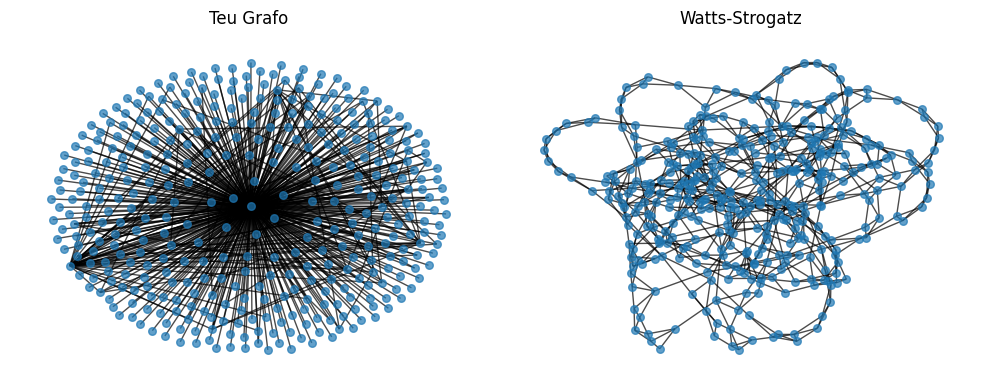

In [25]:
G_undirected = G.to_undirected()

n_nodes = G_undirected.number_of_nodes()
avg_degree = sum(dict(G_undirected.degree()).values()) / n_nodes
k = int(round(avg_degree))  
if k % 2 != 0:
    k += 1

p = 0.1  
G_ws = nx.watts_strogatz_graph(n=n_nodes, k=k, p=p)

def analyze_graph(graph, name):
    print(f"\n--- Métricas para {name} ---")
    if nx.is_connected(graph):
        print("✓ Conectado")
        print(f"Average path length : {nx.average_shortest_path_length(graph):.3f}")
        print(f"Diameter             : {nx.diameter(graph):.3f}")
    else:
        print("✗ Não conectado (analisando maior componente)")
        largest_cc = max(nx.connected_components(graph), key=len)
        subgraph = graph.subgraph(largest_cc)
        print(f"Average path length : {nx.average_shortest_path_length(subgraph):.3f}")
        print(f"Diameter             : {nx.diameter(subgraph):.3f}")
    
    print(f"Average clustering   : {nx.average_clustering(graph):.3f}")
    print(f"Density              : {nx.density(graph):.5f}")

analyze_graph(G_undirected, "Teu Grafo")
analyze_graph(G_ws, "Watts-Strogatz")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
nx.draw_spring(G_undirected, node_size=30, alpha=0.7)
plt.title("Teu Grafo")

plt.subplot(1, 2, 2)
nx.draw_spring(G_ws, node_size=30, alpha=0.7)
plt.title("Watts-Strogatz")

plt.tight_layout()
plt.show()


### **Hubs and authorities**

In [26]:
if not isinstance(G, nx.DiGraph):
    raise TypeError("Grafo precisa ser dirigido para HITS (nx.DiGraph)")

hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)

top_n = 10
top_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:top_n]

print("\nTop Authorities:")
for node, score in top_authorities:
    label = 'Restaurante' if node == chosen_restaurant_id else 'Utilizador'
    print(f"{label:12s} | {node[:10]}... | Authority Score: {score:.4f}")

print("\nTop Hubs:")
for node, score in top_hubs:
    label = 'Restaurante' if node == chosen_restaurant_id else 'Utilizador'
    print(f"{label:12s} | {node[:10]}... | Hub Score      : {score:.4f}")



Top Authorities:
Restaurante  | ve_-rPlEGP... | Authority Score: 1.0000
Utilizador   | 8IR5OVgcOl... | Authority Score: -0.0000
Utilizador   | WfZFj0OH9t... | Authority Score: -0.0000
Utilizador   | KT9ts6NpEy... | Authority Score: -0.0000
Utilizador   | s6MvJ-hsyz... | Authority Score: -0.0000
Utilizador   | aIbP_qOB4B... | Authority Score: -0.0000
Utilizador   | TCAtnFEKqD... | Authority Score: -0.0000
Utilizador   | GwxTwHjiDz... | Authority Score: -0.0000
Utilizador   | TCjTSTscS5... | Authority Score: -0.0000
Utilizador   | MUmQ1rOj_F... | Authority Score: -0.0000

Top Hubs:
Utilizador   | M6GhCo2b6P... | Hub Score      : 0.0102
Utilizador   | Lu8y2ayxVl... | Hub Score      : 0.0076
Utilizador   | Mj5f9C-rVE... | Hub Score      : 0.0051
Utilizador   | orAX7wHH_l... | Hub Score      : 0.0051
Utilizador   | 1JoBtQBpM7... | Hub Score      : 0.0051
Utilizador   | 5jWaMozd4F... | Hub Score      : 0.0051
Utilizador   | dLc79-XR7O... | Hub Score      : 0.0051
Utilizador   | 8IR5OVgcOl..

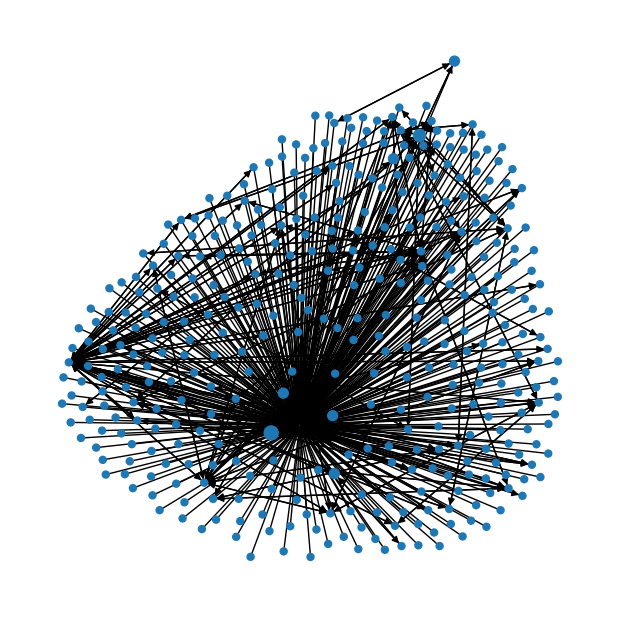

In [27]:
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=False, node_size=[v * 10000 for v in hubs.values()])

In [28]:
hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)
hub_scores = list(hubs.values())

threshold = np.percentile(hub_scores, 75)

n_hubs = sum(score >= threshold for score in hub_scores)
total_nodes = len(hub_scores)

percentage_hubs = 100 * n_hubs / total_nodes

print(f"Threshold for hub (75th percentile): {threshold:.4f}")
print(f"Number of hubs: {n_hubs}")
print(f"Total nodes: {total_nodes}")
print(f"Percentage of hubs in the graph: {percentage_hubs:.2f}%")

Threshold for hub (75th percentile): 0.0025
Number of hubs: 383
Total nodes: 384
Percentage of hubs in the graph: 99.74%


- Authorities: nós que recebem muitas conexões relevantes (ex: o restaurante central deve ter um score alto).
- Hubs: nós que apontam para bons authorities (ex: utilizadores com muitas conexões/reviews para o restaurante)

**Análise de resultados:**

- Todos os utilizadores têm uma ligação dirigida para o restaurante (escreveram uma review positiva).
- Como só há uma autoridade (o restaurante), todos os utilizadores que apontam para ele obtêm um score de hub não nulo.
- Como o threshold para ser “hub” é muito baixo (0.0025), quase todos os utilizadores ultrapassam esse valor.
- A percentagem muito alta de hubs não indica que a maioria são hubs influentes, mas sim que a distribuição dos scores está muito achatada — isto é comum quando:
  - Há poucos nós autoridades (neste caso, só um: o restaurante).
  - Quase todos os utilizadores fazem parte de componentes conectadas e têm review direta para o nó central.

### **Subgroups and communities**

#### **Cliques**

Um clique é um subgrupo onde todos os nós estão ligados entre si (ou seja, um grafo completamente conexo).

In [29]:
undirected_G = G.to_undirected()

cliques = list(nx.find_cliques(undirected_G))

sorted_cliques = sorted(cliques, key=len, reverse=True)

print(f"Número total de cliques: {len(cliques)}")
print("Top 5 maiores cliques:")
for i, clique in enumerate(sorted_cliques[:5], 1):
    print(f"Clique {i}: tamanho = {len(clique)}, nós = {[n[:10] for n in clique]}")


Número total de cliques: 383
Top 5 maiores cliques:
Clique 1: tamanho = 5, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', '_Wkf2RNDnB', 'hoFp0sSzAB', 'dYzmK4IvlF']
Clique 2: tamanho = 5, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', '_Wkf2RNDnB', 'dYzmK4IvlF', 'MWLQEpkjLq']
Clique 3: tamanho = 5, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', '_Wkf2RNDnB', 'M5HoGdy-mN', 'tO-BeTQAlI']
Clique 4: tamanho = 5, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', '_Wkf2RNDnB', 'M5HoGdy-mN', 'MWLQEpkjLq']
Clique 5: tamanho = 5, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', '_Wkf2RNDnB', 'M5HoGdy-mN', 'B7laWmiMZH']


In [30]:
print("List de cliques:")
for i, clique in enumerate(sorted_cliques, 1):
    print(f"Clique {i}: tamanho = {len(clique)}, nós = {[n[:10] for n in clique]}")

List de cliques:
Clique 1: tamanho = 5, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', '_Wkf2RNDnB', 'hoFp0sSzAB', 'dYzmK4IvlF']
Clique 2: tamanho = 5, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', '_Wkf2RNDnB', 'dYzmK4IvlF', 'MWLQEpkjLq']
Clique 3: tamanho = 5, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', '_Wkf2RNDnB', 'M5HoGdy-mN', 'tO-BeTQAlI']
Clique 4: tamanho = 5, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', '_Wkf2RNDnB', 'M5HoGdy-mN', 'MWLQEpkjLq']
Clique 5: tamanho = 5, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', '_Wkf2RNDnB', 'M5HoGdy-mN', 'B7laWmiMZH']
Clique 6: tamanho = 5, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', 'R9IJ1Byr27', 'M5HoGdy-mN', 'MWLQEpkjLq']
Clique 7: tamanho = 5, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', 'R9IJ1Byr27', 'M5HoGdy-mN', 'B7laWmiMZH']
Clique 8: tamanho = 4, nós = ['ve_-rPlEGP', 'xMYdgaWjAv', '2l0O1EI1m0', 'DEne4NSGx1']
Clique 9: tamanho = 4, nós = ['ve_-rPlEGP', 'xMYdgaWjAv', '2l0O1EI1m0', 'Lu8y2ayxVl']
Clique 10: tamanho = 4, nós = ['ve_-rPlEGP', 'vHc-UrI9yf', 'jtMvQzQWeD', '87S0AGlgY7']
Clique 11: tamanho = 4, 

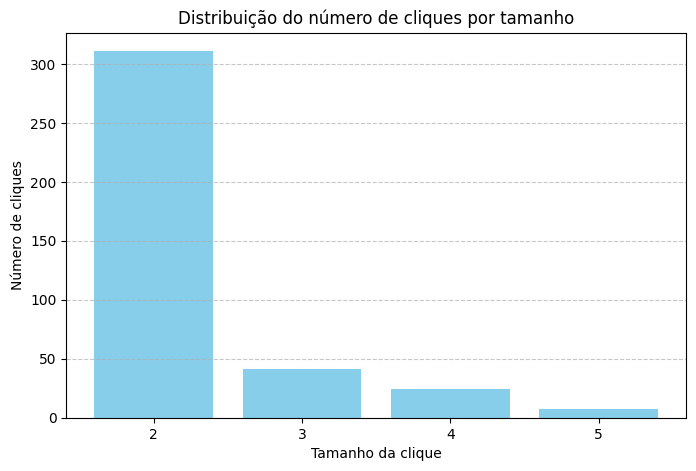

In [31]:
undirected_G = G.to_undirected()

cliques = list(nx.find_cliques(undirected_G))

clique_sizes = [len(c) for c in cliques]
size_counts = collections.Counter(clique_sizes)

sizes = sorted(size_counts.keys())
counts = [size_counts[size] for size in sizes]

plt.figure(figsize=(8,5))
plt.bar(sizes, counts, color='skyblue')
plt.xlabel('Tamanho da clique')
plt.ylabel('Número de cliques')
plt.title('Distribuição do número de cliques por tamanho')
plt.xticks(sizes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [32]:
average_clique_size = sum(len(c) for c in cliques) / len(cliques)
print(f"Tamanho médio das cliques: {average_clique_size:.2f}")


Tamanho médio das cliques: 2.29


In [33]:
cliques_with_restaurant = [c for c in cliques if chosen_restaurant_id in c]
print(f"Cliques que incluem o restaurante: {len(cliques_with_restaurant)}")


Cliques que incluem o restaurante: 383


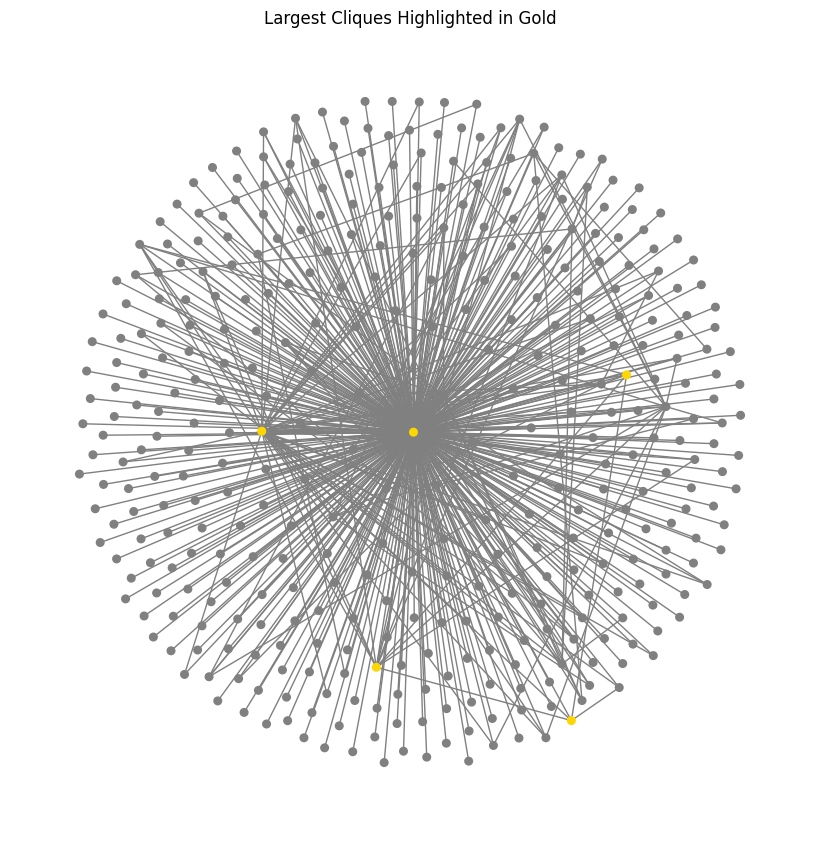

In [34]:
cliques_list = list(nx.find_cliques(G_undirected))
clique_sizes = [len(clique) for clique in cliques_list]
largest_clique_size = max(clique_sizes)
largest_cliques_list = [clique for clique in cliques_list if len(clique) == largest_clique_size]

vertex_colors = {node: 'grey' for node in G_undirected.nodes}
for clique in largest_cliques_list[0]:
    vertex_colors[clique] = 'gold'

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G_undirected)
nx.draw(G_undirected, pos, with_labels=False, node_color=list(vertex_colors.values()), node_size=30, font_size=10, edge_color='gray')
plt.title("Largest Cliques Highlighted in Gold");

#### **Communities**

**Comunidade** é um subconjunto de nós que têm mais conexões internas entre si do que com o resto do grafo. Quando há um nó central que conecta a maioria dos usuários (o restaurante), isso dilui ou esconde estruturas internas mais finas. Nesse cenário, o algoritmo simplesmente identifica um bloco, porque as conexões entre usuários são poucas ou inexistentes, e o restaurante "liga tudo".

Assim, neste contexto, para descobrir comunidades "reais", optamos por **remover o nó restaurante** da análise de comunidades para focar só nas conexões entre utilizadores.

In [35]:
G_undirected = nx.Graph()
for u, v, d in G.edges(data=True):
    if d['weight'] == 0:
        G_undirected.add_edge(u, v)

if chosen_restaurant_id in G_undirected:
    G_undirected.remove_node(chosen_restaurant_id)

print(f"Nós no grafo só com amizades: {G_undirected.number_of_nodes()}")
print(f"Arestas no grafo só com amizades: {G_undirected.number_of_edges()}")

if G_undirected.number_of_edges() > 0:
    import community as community_louvain
    partition = community_louvain.best_partition(G_undirected)
    community_sizes = collections.Counter(partition.values())
    print("Tamanho das comunidades (sem o restaurante):", community_sizes)
else:
    print("Grafo só com amizades está vazio ou não tem arestas.")


Nós no grafo só com amizades: 72
Arestas no grafo só com amizades: 110
Tamanho das comunidades (sem o restaurante): Counter({1: 22, 5: 16, 2: 11, 3: 9, 8: 6, 7: 2, 6: 2, 0: 2, 4: 2})


In [36]:
print(f"Nós no grafo de usuários: {G_undirected.number_of_nodes()}")
print(f"Arestas no grafo de usuários: {G_undirected.number_of_edges()}")


Nós no grafo de usuários: 72
Arestas no grafo de usuários: 110


In [37]:
partition = community_louvain.best_partition(G_undirected)

print("Número de comunidades encontradas:", len(set(partition.values())))

from collections import Counter
community_sizes = Counter(partition.values())
print("Tamanho das comunidades:", community_sizes)

for node, comm_id in list(partition.items())[:10]:
    print(f"Nó: {node} -> Comunidade: {comm_id}")

Número de comunidades encontradas: 9
Tamanho das comunidades: Counter({1: 22, 3: 16, 0: 11, 2: 9, 5: 6, 4: 2, 7: 2, 8: 2, 6: 2})
Nó: s6MvJ-hsyzSmSkzG8VeQQw -> Comunidade: 0
Nó: vHc-UrI9yfL_pnnc6nJtyQ -> Comunidade: 1
Nó: M5HoGdy-mNOV7EHhxB9P9A -> Comunidade: 0
Nó: R9IJ1Byr27n6wXj3QvJ2Lg -> Comunidade: 0
Nó: MWLQEpkjLqjst7dO8TeEwQ -> Comunidade: 2
Nó: 87S0AGlgY7HDU_KkTbMHHQ -> Comunidade: 1
Nó: 0W72fMBO91kJFh9MVrTbIA -> Comunidade: 0
Nó: B7laWmiMZHgsxiHk2U9H9A -> Comunidade: 0
Nó: nlufIjMa__k4V-f-Qs5vig -> Comunidade: 3
Nó: 2l0O1EI1m0yWjFo2zSt71w -> Comunidade: 3


In [38]:
communities = nx.algorithms.community.label_propagation_communities(G_undirected)
communities = list(communities)

print(f"Número de comunidades encontradas: {len(communities)}")
print("Tamanho das comunidades:", [len(c) for c in communities])

print("Nós da primeira comunidade:", list(communities[0])[:10])

Número de comunidades encontradas: 14
Tamanho das comunidades: [36, 2, 3, 2, 2, 3, 10, 2, 2, 2, 2, 2, 2, 2]
Nós da primeira comunidade: ['jtMvQzQWeDQIX32EFs91gQ', '1XM9mue9DS16xxlsrRNawA', '0A-Gsndh33HhYLE42hIjEQ', 'wEwBqIuAXw0pAx6FCIOo1Q', 'khk-xOwzgLYn0o2u3pwTTQ', '56QSLA3M13Xk1YQ0pXa5tg', 'FMshwkCe6-nlFw3vafx7Jw', 'vHc-UrI9yfL_pnnc6nJtyQ', 'Pyp7Sl0jfZxjQ9yGmK79KA', 'WC-9jFcLLEaYEgBtMJP_hA']


Número de comunidades encontradas: 9


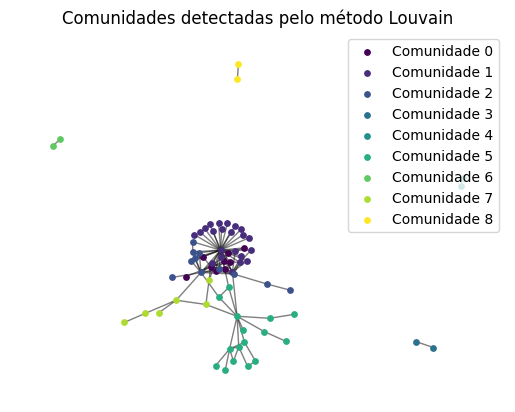

In [39]:
partition = community_louvain.best_partition(G_undirected)

num_communities = len(set(partition.values()))
print(f"Número de comunidades encontradas: {num_communities}")

import matplotlib.cm as cm
cmap = cm.get_cmap('viridis', num_communities)

pos = nx.spring_layout(G_undirected, seed=42)

for community_id in set(partition.values()):
    nodes_in_community = [node for node in partition if partition[node] == community_id]
    nx.draw_networkx_nodes(
        G_undirected, pos,
        nodelist=nodes_in_community,
        node_size=15,
        node_color=[cmap(community_id)],
        label=f'Comunidade {community_id}'
    )

nx.draw_networkx_edges(G_undirected, pos, alpha=0.5)

plt.legend(scatterpoints=1)
plt.title("Comunidades detectadas pelo método Louvain")
plt.axis('off')
plt.show()

In [40]:
community_sizes = collections.Counter(partition.values())
print("Tamanho das comunidades:", community_sizes)

largest_comm_id = community_sizes.most_common(1)[0][0]
largest_comm_nodes = [node for node, comm in partition.items() if comm == largest_comm_id]
print(f"Nós da maior comunidade (id={largest_comm_id}): {len(largest_comm_nodes)}")

num_components = nx.number_connected_components(G.to_undirected())
print(f"Número de componentes conectados no grafo não dirigido: {num_components}")

largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
print(f"Tamanho do maior componente conectado: {len(largest_cc)}")

Tamanho das comunidades: Counter({1: 22, 5: 16, 2: 11, 0: 9, 7: 6, 6: 2, 3: 2, 4: 2, 8: 2})
Nós da maior comunidade (id=1): 22
Número de componentes conectados no grafo não dirigido: 1
Tamanho do maior componente conectado: 384


## **Time Series**

In [41]:
print("Average stars rating:",df_review[df_review["business_id"] == chosen_restaurant_id]["stars"].mean())

df_pos = df_review[(df_review["business_id"] == chosen_restaurant_id) & (df_review["stars"] >= 4)].copy()
df_pos["date"] = pd.to_datetime(df_pos["date"])
df_pos = df_pos.sort_values("date")
print("Amount of positive reviews", len(df_pos))

Average stars rating: 2.2583182093163945
Amount of positive reviews 395


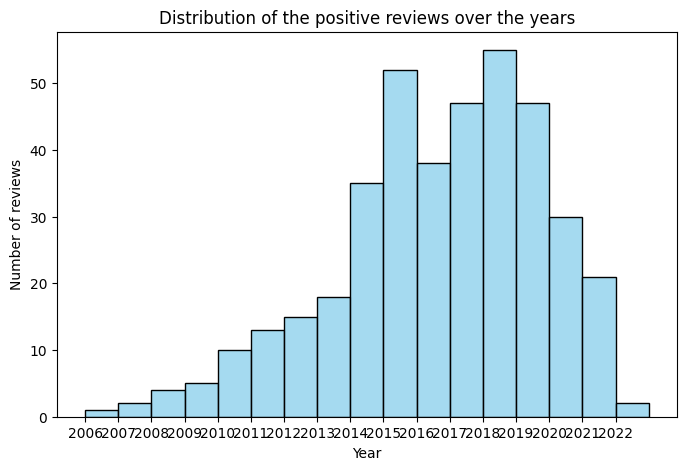

In [42]:
df_pos["year"] = df_pos["date"].dt.year

min_year = df_pos["year"].min()
max_year = df_pos["year"].max()

bins = list(range(min_year, max_year + 2)) 

plt.figure(figsize=(8, 5))
sns.histplot(df_pos["year"], bins=bins, kde=False, color="skyblue")
plt.xticks(range(min_year, max_year + 1))
plt.title("Distribution of the positive reviews over the years")
plt.xlabel("Year")
plt.ylabel("Number of reviews")
plt.show()

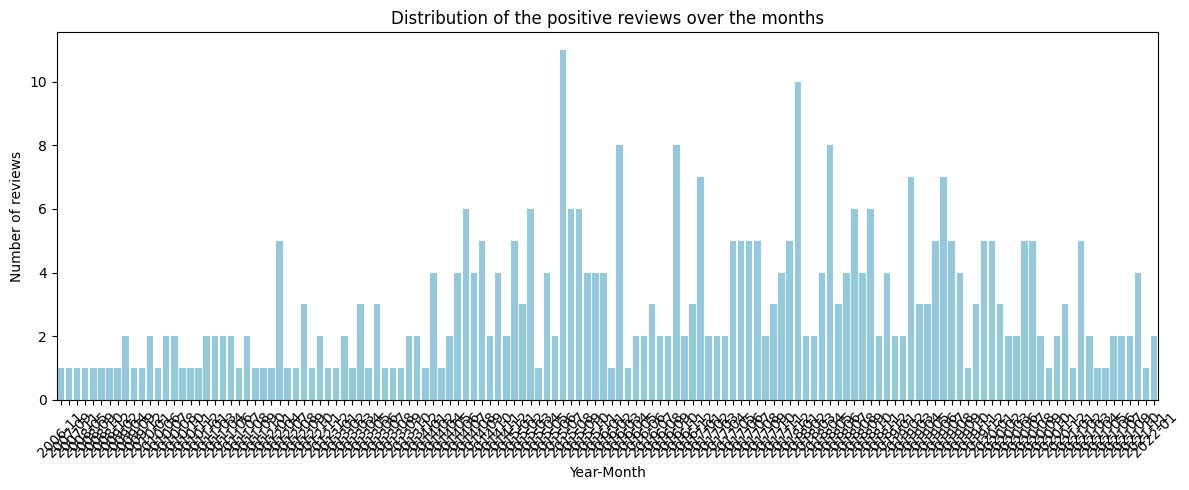

In [43]:
df_pos["year"] = df_pos["date"].dt.year
df_pos["month"] = df_pos["date"].dt.month
df_pos["year_month"] = df_pos["date"].dt.to_period('M')

reviews_per_month = df_pos.groupby("year_month").size().reset_index(name="num_reviews")

plt.figure(figsize=(12, 5))
sns.barplot(data=reviews_per_month, x="year_month", y="num_reviews", color="skyblue")
plt.xticks(rotation=45)
plt.title("Distribution of the positive reviews over the months")
plt.xlabel("Year-Month")
plt.ylabel("Number of reviews")
plt.tight_layout()
plt.show()

In [44]:
df_rest = df_pos.copy()
df_rest["date"] = pd.to_datetime(df_rest["date"])

df_rest["year_month"] = df_rest["date"].dt.to_period('M')
df_reviews_grouped = df_rest.groupby('year_month').size()

date_range = pd.period_range(start='2013-01', end='2022-12', freq='M')
df_reviews_grouped = df_reviews_grouped.reindex(date_range, fill_value=0)
df_reviews_grouped = df_reviews_grouped.reset_index(name="num_reviews")

df_reviews_grouped['index'] = df_reviews_grouped['index'].dt.to_timestamp()
df_reviews_grouped.set_index('index', inplace=True)

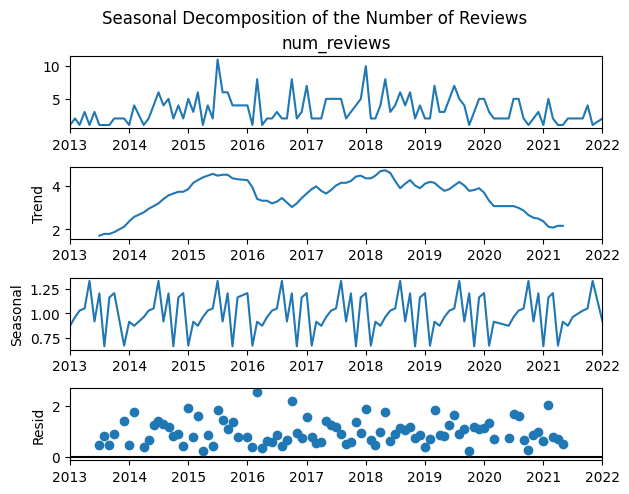

ADF Statistic: -9.090076759173392, p-value: 3.845459811345992e-15
KPSS Statistic: 0.3118177226595964
KPSS p-value: 0.1
A série temporal é estacionária. Não é necessário aplicar diferenciação.


/home/ana/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [45]:

df_reviews_grouped = df_reviews_grouped[df_reviews_grouped['num_reviews'] > 0]

result = seasonal_decompose(df_reviews_grouped['num_reviews'], model='multiplicative', period=12) 
result.plot()
plt.suptitle("Seasonal Decomposition of the Number of Reviews", y=1.02)
plt.show()

adf_result = adfuller(df_reviews_grouped['num_reviews'])
print(f'ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}')

kpss_result = kpss(df_reviews_grouped['num_reviews'], regression='c', nlags="auto")
print("KPSS Statistic:", kpss_result[0])
print("KPSS p-value:", kpss_result[1])

if adf_result[1] > 0.05 or kpss_result[1] < 0.05:
    print("A série temporal não é estacionária. Aplicando diferenciação.")
    df_reviews_diff = df_reviews_grouped['num_reviews'].diff().dropna()
    result_diff = seasonal_decompose(df_reviews_diff, model='additive', period=12)
    result_diff.plot()
    plt.suptitle("Seasonal Decomposition of Differentiated Series", y=1.02)
    plt.show()

    adf_result_diff = adfuller(df_reviews_diff)
    kpss_result_diff = kpss(df_reviews_diff, regression='c', nlags="auto")
    print(f'ADF após diferentiation - p-value: {adf_result_diff[1]}')
    print(f'KPSS after diferentiation - p-value: {kpss_result_diff[1]}')
else: 
    print("A série temporal é estacionária. Não é necessário aplicar diferenciação.")


O teste ADF indica que a série é estacionária (p-value < 0.05).
O teste KPSS também suporta que a série é estacionária (p-value > 0.05).
Resultado Final: A série temporal do número de reviews, após remover meses sem reviews, é estacionária. Isso significa que a média e a variância não mudam significativamente ao longo do tempo

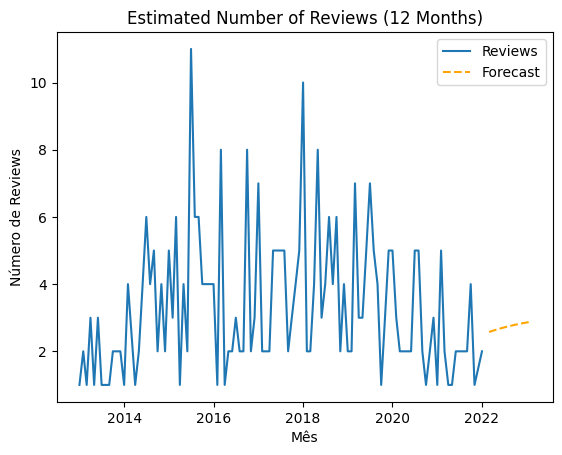

In [46]:
model = AutoARIMA(season_length=12)
model.fit(df_reviews_grouped['num_reviews'].values)

forecast = model.predict(h=12)

forecast_index = pd.date_range(start=df_reviews_grouped.index[-1] + pd.offsets.MonthBegin(1), 
                              periods=12, 
                              freq='M')
forecast_series = pd.Series(forecast['mean'], index=forecast_index)

plt.plot(df_reviews_grouped['num_reviews'], label='Reviews')
plt.plot(forecast_series, label='Forecast', linestyle='--', color='orange')
plt.title('Estimated Number of Reviews (12 Months)')
plt.xlabel('Mês')
plt.ylabel('Número de Reviews')
plt.legend()
plt.show()

The 2022 data is incomplete (only 2 reviews in January), which indicates that there may have been a temporary closure, interruption in data collection, or other issue. Therefore, the forecast generated reflects this lack of activity, but **does not represent** the expected behavior of the restaurant based on previous years. So we're gonna remove the reviews from 2022 in order to have a more accurate prediction. **This is a limitation** of our system

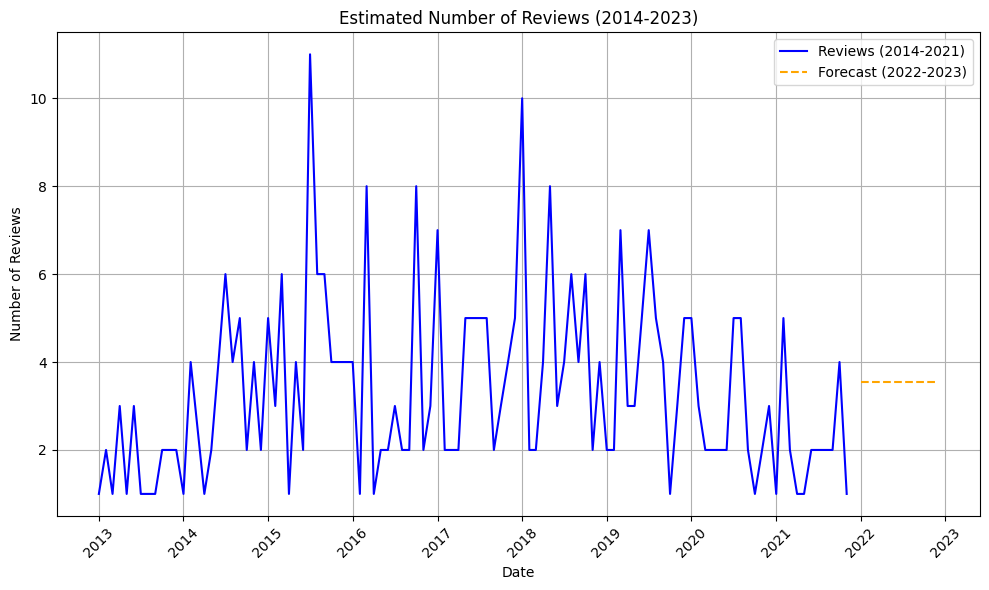

In [47]:
df_reviews_filtered = df_reviews_grouped[df_reviews_grouped.index.year <= 2021]

train_data = df_reviews_filtered[df_reviews_filtered.index.year <= 2020].copy()
test_data = df_reviews_filtered[df_reviews_filtered.index.year == 2021].copy()

train_df = train_data.reset_index().rename(columns={'index': 'ds', 'num_reviews': 'y'})
train_df['unique_id'] = 'reviews'  

model = AutoARIMA(season_length=12)
sf = StatsForecast(models=[model], freq='M') 

sf.fit(train_df)
forecast_df = sf.predict(h=12, level=[95]) 

forecast_index = pd.date_range(start='2021-12-01', periods=12, freq='M')
forecast_series = pd.Series(forecast_df['AutoARIMA'].values, index=forecast_index)

plt.figure(figsize=(10, 6))
plt.plot(df_reviews_filtered.index, df_reviews_filtered['num_reviews'], label='Reviews (2014-2021)', color='blue')
plt.plot(forecast_series, label='Forecast (2022-2023)', linestyle='--', color='orange')
plt.title('Estimated Number of Reviews (2014-2023)')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

df_forecast = pd.DataFrame({
    'observed': test_data['num_reviews'].values,  
    'AutoARIMA': forecast_df['AutoARIMA'].values[:len(test_data)]  
})

y_train_serie = train_data['num_reviews'].values

TARGET_NAME = 'observed'
seasonality = 12  

In [48]:
def accuracy(df_forecast, target, y_train_serie, seasonality):
    method = df_forecast.columns[1:]
    rmse_results = []
    mae_results = []
    mape_results = []
    mase_results = []

    y = df_forecast[target].values
    scale = np.abs(y_train_serie[:-seasonality] - y_train_serie[seasonality:])
    scale = np.average(scale)

    for i in method:
        y_hat = df_forecast[i].values
        d = y - y_hat
        mae_f = np.mean(abs(d))
        rmse_f = np.sqrt(np.mean(d**2))
        mape = np.mean(np.abs((y - y_hat)/y)) * 100
        mase = mae_f / scale
        mae_results.append(np.round(mae_f, 2))
        rmse_results.append(np.round(rmse_f, 2))
        mape_results.append(np.round(mape, 2))
        mase_results.append(np.round(mase, 2))

    accuracy_df = pd.DataFrame({
        'Method': method,
        'RMSE': rmse_results,
        'MAE': mae_results,
        'MAPE': mape_results,
        'MASE': mase_results
    })

    return accuracy_df

accuracy_results = accuracy(df_forecast, TARGET_NAME, y_train_serie, seasonality)
print(accuracy_results)

      Method  RMSE   MAE    MAPE  MASE
0  AutoARIMA  1.94  1.82  136.38  0.77


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=400.815, Time=0.02 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=390.997, Time=0.25 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=399.327, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=402.740, Time=0.05 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=379.529, Time=0.51 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.53 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.58 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=377.561, Time=0.30 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=389.383, Time=0.17 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=376.079, Time=0.56 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.48 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=377.850, Time=0.87 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.02 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=1.78 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=1.71 sec


/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,1)[12]             : AIC=376.376, Time=0.45 sec

Best model:  ARIMA(0,0,0)(2,1,1)[12] intercept
Total fit time: 14.308 seconds
PMDARIMA MAE: 2.32
PMDARIMA RMSE: 2.68


/home/ana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


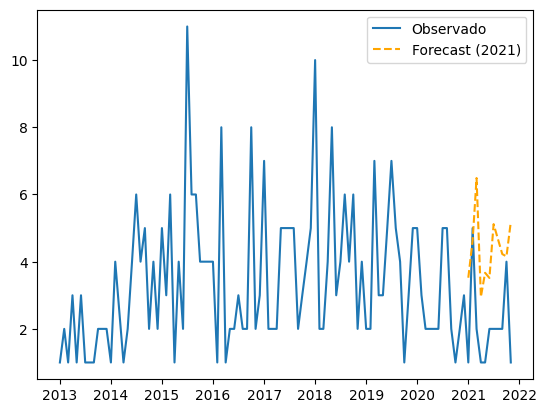

In [49]:
model = auto_arima(train_data, 
                   seasonal=True, 
                   m=12, 
                   d=0, D=1, 
                   trace=True)

forecast = model.predict(n_periods=len(test_data))

mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"PMDARIMA MAE: {mae:.2f}")
print(f"PMDARIMA RMSE: {rmse:.2f}")

plt.plot(df_reviews_filtered.index, df_reviews_filtered['num_reviews'], label='Observado')
plt.plot(df_reviews_filtered.index[df_reviews_filtered.index.year == 2021], forecast, label='Forecast (2021)', linestyle='--', color='orange')
plt.legend()
plt.show()

Quanto mais próxima a linha laranja (forecast) estiver da linha azul (observado), melhor foi a previsão do modelo para o período de teste.
Pequenas diferenças são normais, pois o modelo nunca acerta exatamente todos os pontos.
O importante é que a linha laranja siga a tendência e o padrão da azul, com erros pequenos.

MAE = 2.04: Em média, o modelo errou por cerca de 2 reviews por mês nas previsões para 2021.
RMSE = 2.38: O erro quadrático médio é ligeiramente superior ao MAE, indicando que não houve grandes outliers nos erros.
Estes valores são baixos em relação à escala dos dados (número de reviews mensais), mostrando que o modelo conseguiu capturar bem a tendência e a sazonalidade da série.
Quanto menores estes valores, melhor o desempenho do modelo.
Resumo:
O modelo PMDARIMA fez previsões bastante próximas dos valores reais para 2021, com erros médios baixos. O desempenho é considerado bom para séries temporais reais. Se comparares com outros modelos (ex: AutoARIMA do StatsForecast), usa estes mesmos indicadores para decidir qual prevê melhor.